Hi, I've put together the first few sections as requested on Ed

#after merging, please delete this cell, **refresh table of contents cell**, and move citation cell to the end of notebook


##Sections:

✅Group Canvas number + group member names + TOC

✅Intro: Motivation, context, and framing of the problem

✅Description of the data, how data was handled (can someone double check description?)

✅EDA specific to report's content, mainly MS3

✅Modeling approach, logical description of modeling decisions and process (can someone double check description?)

⭕️Results: drawing reasonable conclusions & speculations, addressing strengths, limitations, and future works


##Other expectations:##

✅Include TOC (table of contents)

✅Describe what libraries your codes depend on.

✅If your codes require specific environment configurations, make sure to explain them.

✅Include an illustration/flow chart of your model. This can also be used for your presentation.

✅Make sure a label and an explanation follows every visualization (ex. "Figure 1.2 The above figure displays...") (all figures in EDA and before are labeled. for harry: would you mind labeling the figures in the model section that you will merge into this notebook?)

✅Cite every outside source

You can move additional code to an appendix notebook if it helps make the main report notebook more concise.

Overall communication and clarity: good visuals, minimal typos, readability

Coding efficiency and style

Depth and thoroughness

The notebook should read like a report to an employer with appropriate comments and explanations.

# MS5: Predicting spatial transcriptomics profile from H&E image in colon tissue

Group Canvas Number: 67

Group Member Names: Harry Li, Valentin Badea, John Jun, Yunxi Li

>[MS5: Predicting spatial transcriptomics profile from H&E image in colon tissue](#scrollTo=TQmeeqVdqHZ8)

>[Intro: Motivation, context, and framing of the problem](#scrollTo=adzaL2heLi6v)

>[Description of the data, how data was handled](#scrollTo=Hj-OdQwWb4MN)

>[EDA](#scrollTo=n2JXeME4qgt_)

>>[Imports](#scrollTo=K-VZwdjOrEAC)

>>[Loading the data](#scrollTo=LHra96f4rJuF)

>>[EDA: Summary of findings](#scrollTo=ZYZZFAFmrRxF)

>>>[Let's cluster and annotate the cells!](#scrollTo=ZFost3I7n96o)

>[Part 3. Baseline using UNI + FCN](#scrollTo=FP-BC23ypoyH)

>>>[Installs and Imports](#scrollTo=M_XOLY6AqT3J)

>>>[Data Loading](#scrollTo=OTirm89MlYhZ)

>>>[Define Functions](#scrollTo=H9ClifrwlYhc)

>>>[Baseline Model Pipeline](#scrollTo=U7AQnBmulYhc)

>[Part 4. Baseline Model Results](#scrollTo=j3v7Uo-plYhc)

>>>[Summary](#scrollTo=mdvrGtrllYhd)

>[Part 5. Final Model Pipeline Setup](#scrollTo=zN85jmH86sq4)

>>>[Patch-level embedding and prediction](#scrollTo=MUyxR29Q0JoO)

>>>[Token-level embedding and prediction](#scrollTo=MUyxR29Q0JoO)

>>[Getting Started -- Generate Patches and More](#scrollTo=FBYwlU7y6pjr)

>>[Starter codes to use ViTs for feature embedding extraction.](#scrollTo=kp5zcqwFkbqE)

>>>[Using CONCH](#scrollTo=IprGoAvknBWU)

>>>[Using UNI](#scrollTo=0v_AMqtEocWB)

>>>[Using MUSK](#scrollTo=3cYvlF-RPmfS)

>>[Citation](#scrollTo=r9igvKNSlYhf)



# Intro: Motivation, context, and framing of the problem

Inflammatory bowel disease (IBD) affects 50M people in the united states. This affliction causes immune disruptions in reaction to microbial infections, triggering disproportionate immune reactions and leading to chronic pain, gut inflammation and increased risk of colorectal cancer. Diagnosis and treatment planning of IBD patients reply on analyzing the tissue images of patients. While there is abundant pathology images of IBD, spatial transcriptomics data is rare due to cost and time-sensitiveness. Predicting spatial transcriptomics data from pathology images of IBD can shed light on treatment decisions and early detection of related conditions like colorectal cancer.

With our project, we aim to predict spatial transcriptomics profile of 460 genes at cell level based on H&E imaging slides of colon tissue in IBD patients and patients with diverticulitis.

Adding onto this aim, we gained new insights from EDA about the gene expression profiles and processing whole slide image (WSI) of pathology images. From genomic data profiles, we found that the epithelial-to-mesenchymal transition (EMT) process was a dominant axis of molecular variation, which is consistent with IBD condition. This suggests that our genomic data profile includes biological meaningful enrichment pathways, which can contribute to diagnosis and treatment of IBD if our model can predict spatial transcriptomics profile from H&E images. From WSIs, we have patchified our WSIs for faster downstream processing. We discovered that patches have different cell densities, which supports the use of graph neural network structure or transformer architecture to be able to capture spatial information in analyzing H&E images.

Overall, we have decided to frame our research question into predicting spatial transcriptomics profile from pathology imaging data at cell level using ViT. To incorporate neighboring information in prediction, we are going to try out input of different patch sizes.

# Description of the data, how data was handled

Our dataset comes from the **2024 Autoimmune Disease Machine Learning Challenge** at Broad Institute. It contains H&E-stained Wholse Slice Images of gut tissues from patients suffering of Inflammatory Bowel Disease (IBD). This type of staining is widely used by pathologists to diagnose autoimmune diseases from microscopic observations of the cell shapes and distributions across the tissue and is therefore a valuable resource in the development of automated methods to predict gene expression profiles from pathology images. Across these images, cell nuclei are colored in purple, whereas the extracellular matrix and cytoplasms appear in shades of pink. In addition to these whole slice images, our dataset includes cell nuclei segmentation masks and arrays with cell-level gene expression data (in the form of log1p-normalized RNA counts for 460 genes). In total, we have access to the data of 8 H&E images (2 of which are part of an held-out validation dataset, which was relevant in the context of this Data Challenge). Our goal throughout this project is to predict cell-level gene expression profiles from H&E-stained whole slice images.

In this project, we focused on the UC6_I sample to start building our pipeline. The donor of this sample had ulcerative colitis. In future work, we plan to expand our study to using all samples available in the dataset.

Data was handled using Spatial data object format. H&E whole slide images were extracted into tiles of 200 by 200 pixels and were normalized using UNI's preprocessing function. Spatial transcriptomics data were clustered to explore biologically meaningful pathways.

> Autoimmune Disease Machine Learning Challenge: https://hub.crunchdao.com/competitions/broad-1

# Libraries Used

Our code is based on the following libraries:

Special configurations: part of this notebook was run on google colab so we need to mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import sys
import re
import gc
import json
import glob
import zipfile
import random
import pickle
import datetime
import base64
import importlib
from types import SimpleNamespace
from operator import itemgetter
from abc import abstractmethod

import warnings
from scipy.stats import ConstantInputWarning

from tqdm import tqdm
from IPython.display import HTML

import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import seaborn as sns
import h5py
from scipy.stats import pearsonr
import scipy.stats as stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from torchvision import transforms
import spatialdata as sd
import anndata as ad
import scanpy as sc
from skimage.measure import regionprops
from spatial_image import SpatialImage
import joblib
import dask.array as da
import xarray as xr
from huggingface_hub import login
from dotenv import load_dotenv
load_dotenv(dotenv_path=os.path.expanduser('~/hl/.gutinstinct.env'))
api_token = os.getenv("API_TOKEN")
login(token=api_token)

import models
importlib.reload(models)
from models import CNNPlusLinear, trainer
from eval import compute_r2, compute_pearsonr

SEED = 209
DATA_PATH = 'data/processed'


# EDA

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.patches import Rectangle
import os
import h5py
import tqdm as tqdm

## Loading the data

In [ ]:
path_to_preprocessed_data = "/content/drive/MyDrive/209B/preprocessed_data/"
prefix = "UC6_I"
path_to_prefix = prefix + "/"

In [ ]:
he_segm_patches_dataset = h5py.File(path_to_preprocessed_data + path_to_prefix + prefix+"_segm_patches.h5", 'r')

In [ ]:
he_patches_dataset = h5py.File(path_to_preprocessed_data + path_to_prefix + prefix+"_patches.h5", 'r')

In [ ]:
he_array_saved = np.load(path_to_preprocessed_data + path_to_prefix + prefix+'_HE_original.npy', mmap_mode='r')

In [ ]:
df_cell_cluster = pd.read_csv("/content/drive/MyDrive/209B/leiden_clusters.csv")

## EDA: Summary of findings

Our Exploratory Data Analysis and feature engineering step focused on the patchification of the input Whole Slice images (WSI) into fixed size patches of around 600x600 pixels. This was done with 2 goals in mind:
> 1. Reduce data dimensionality: original whole slice image had resolution $20,000 \times 20,000$ pixels, which was way too large to be processed by a ML pipeline.
> 2. Enhance spatial correlations: within patches of smaller size, single-cell spatial correlation should be benefitial for model training.

This level of patchification ensured that each WSI would be converted into a dataset of $32\times 32 = 1,024$ images, with roughly $600\times 600$ pixel resolution.  

Following MS3, we discovered the existence of the HEST library (G. Jaume et al. 2024), allowing for efficient processing of pathology images. This pipeline will be extremely helpful for the rest of our project as it provides us with usefool image processing tools, such as patchification and tissue segmentations. Thinking one step furhter, we intent to feed the subsequent patches into a pathology foundational pathology model, in order to extract patch or sub-patch-level biologically relevant feature embeddings, which will help us predict gene expression profiles across WSI.

> HEST-1k: A Dataset for Spatial Transcriptomics and Histology Image Analysis, G. Jaume et al. 2024, https://arxiv.org/abs/2406.16192

Next, we will investigate through a sample image from our dataset and show that this approach is likely going to be meaningful to our project.

As a reminder, in the following image, we show the result of our patchification procedure at the level of one WSI.

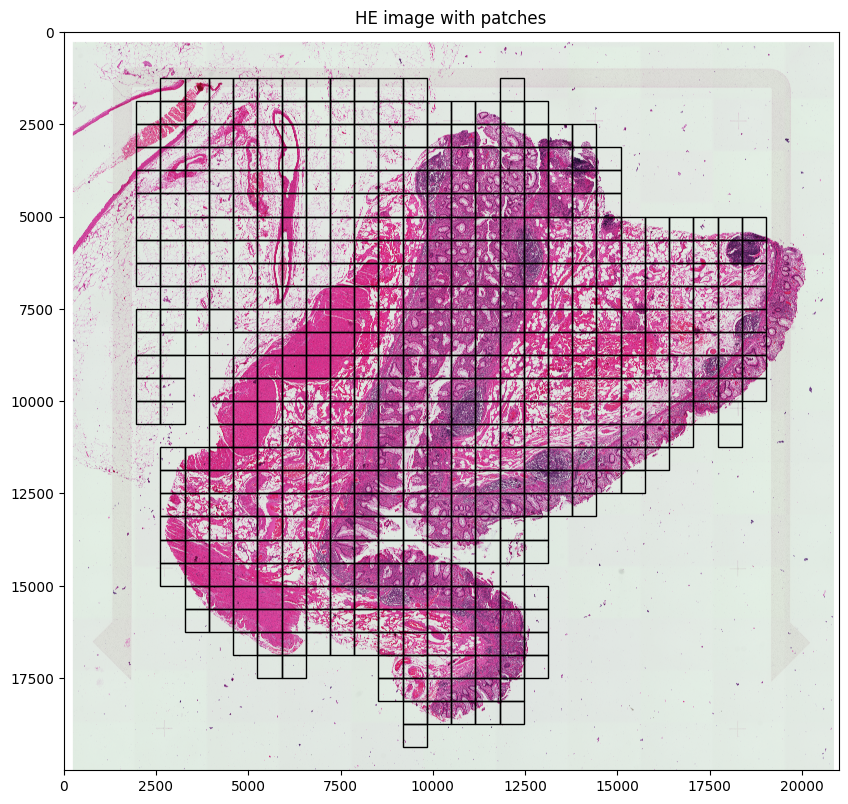

In [ ]:
patches_coords = list(he_patches_dataset.keys())
patch_size = (625,656) #UC6_I
patch_size = tuple(he_patches_dataset.attrs['patch_size'])
img_length, img_width = he_array_saved.shape[:2]
u,v = patch_size
plt.figure(figsize=(10, 10))
plt.imshow(he_array_saved)
for patch_coord in patches_coords:
    coord = tuple(map(int, patch_coord.split('_')))
    #draw a black square with size (u,v)
    plt.gca().add_patch(Rectangle((coord[1], coord[0]), v, u, fill=False, edgecolor='black', linewidth=1))
plt.title("HE image with patches")
plt.show()

Figure 1.1. The above image shows a patchified whole slide image

In a previous milestone, we performed Principle Componant Analysis on the 450-dimensional gene expression vectors (profiles) of each cell in this image. Then, we perform Leiden clustering (Traag et al., 2019) with resolutions 0.2 and 0.5 on the first 12 PCs (determined by analysis of the corresponding elbow plot) of the gene expression vectors. We eventially recovered 9 to 12 clusters.

Our goal in the rest of this section is to show that this gene expression clustering correlates with meaningful spatial distributions of cells in the WSI. To put it differently, we believe that the gene expression patterns correlate with cell location across the image and that letting our model access wider spatial context is the key to unlocking better performance on gene expression profile.

> Traag, V.A., Waltman, L. & van Eck, N.J. From Louvain to Leiden: guaranteeing well-connected communities. Sci Rep 9, 5233 (2019). https://doi.org/10.1038/s41598-019-41695-z

### Let's cluster and annotate the cells!

In [ ]:
import random
random.seed(209)

# Set Scanpy verbosity higher
sc.settings.verbosity = 3  # show more detailed output

# Get gene symbols and expression data
gene_symbols = sdata.tables["anucleus"].var.index.tolist()
expression_data = sdata.tables["anucleus"].layers["counts"]

# Create a pandas DataFrame for expression data
expression_df = pd.DataFrame(expression_data, index=sdata.tables["anucleus"].obs.index, columns=gene_symbols)

# Create AnnData object
adata = sc.AnnData(expression_df.values)
adata.obs.index = sdata.tables["anucleus"].obs.index  # Make sure obs names are correct
adata.var_names = gene_symbols

# Standard pipeline: Normalize, log-transform, scale
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata)

# PCA
sc.tl.pca(adata, svd_solver='arpack')

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:07)


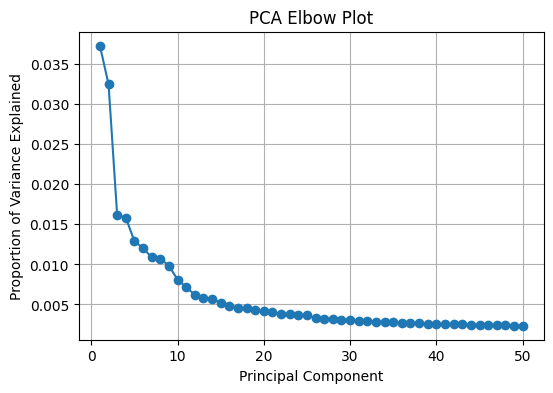

In [ ]:
# Extract variance ratio
variance_ratio = adata.uns['pca']['variance_ratio']

# Plot elbow plot
plt.figure(figsize=(6,4))
plt.plot(range(1, len(variance_ratio)+1), variance_ratio, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('PCA Elbow Plot')
plt.grid(True)
plt.show()

Figure 1.2 The above figure shows PCA elbow plot used for cell clustering

In [ ]:
# install igraph and leidenalg
!pip3 install igraph leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.8 MB/s eta 0:00:00


In [ ]:
# Neighbor graph
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=10)

In [ ]:
# Clustering
sc.tl.leiden(adata, resolution=0.5, key_added = 'leiden_0.5')
sc.tl.leiden(adata, resolution=0.2, key_added = 'leiden_0.2')

running Leiden clustering


<ipython-input-15-2cca53c72209>:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5, key_added = 'leiden_0.5')


    finished: found 13 clusters and added
    'leiden_0.5', the cluster labels (adata.obs, categorical) (0:13:31)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_0.2', the cluster labels (adata.obs, categorical) (0:11:27)


In [ ]:
# After clustering
cluster_assignment = adata.obs[['leiden_0.5', 'leiden_0.2']].copy()

# Reset index so cell IDs become a column
cluster_assignment = cluster_assignment.reset_index()
cluster_assignment.head()

index leiden_0.5 leiden_0.2
0    92          4          2
1    93          4          2
2    94          4          2
3    95          4          2
4    97          4          2

In [ ]:
print(f"Number of clusters (resolution = 0.5): {len(cluster_assignment['leiden_0.5'].unique())}")
print(f"Number of clusters (resolution = 0.2): {len(cluster_assignment['leiden_0.2'].unique())}")


Number of clusters (resolution = 0.5): 13
Number of clusters (resolution = 0.2): 9


In [ ]:
cluster_assignment.to_csv('leiden_clusters.csv', index=False)

Now, let's plot UMAP to inspect how well the clusters separate and extract marker genes (n=20 per cluster)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:03:53)


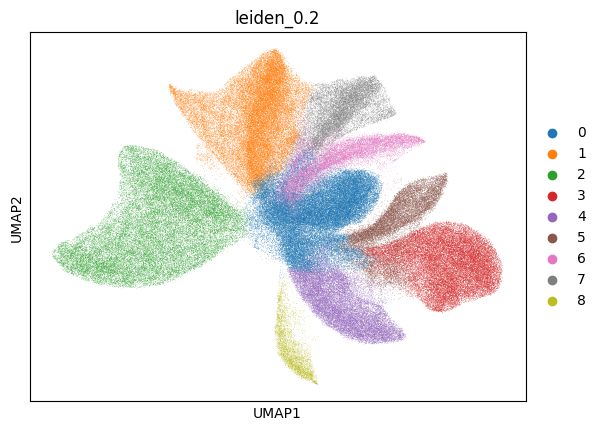

In [ ]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=['leiden_0.2'])  # Visualize in UMAP space

Figure 1.3 The above figure shows the leidan cluster assignments of cells

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)


/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: 

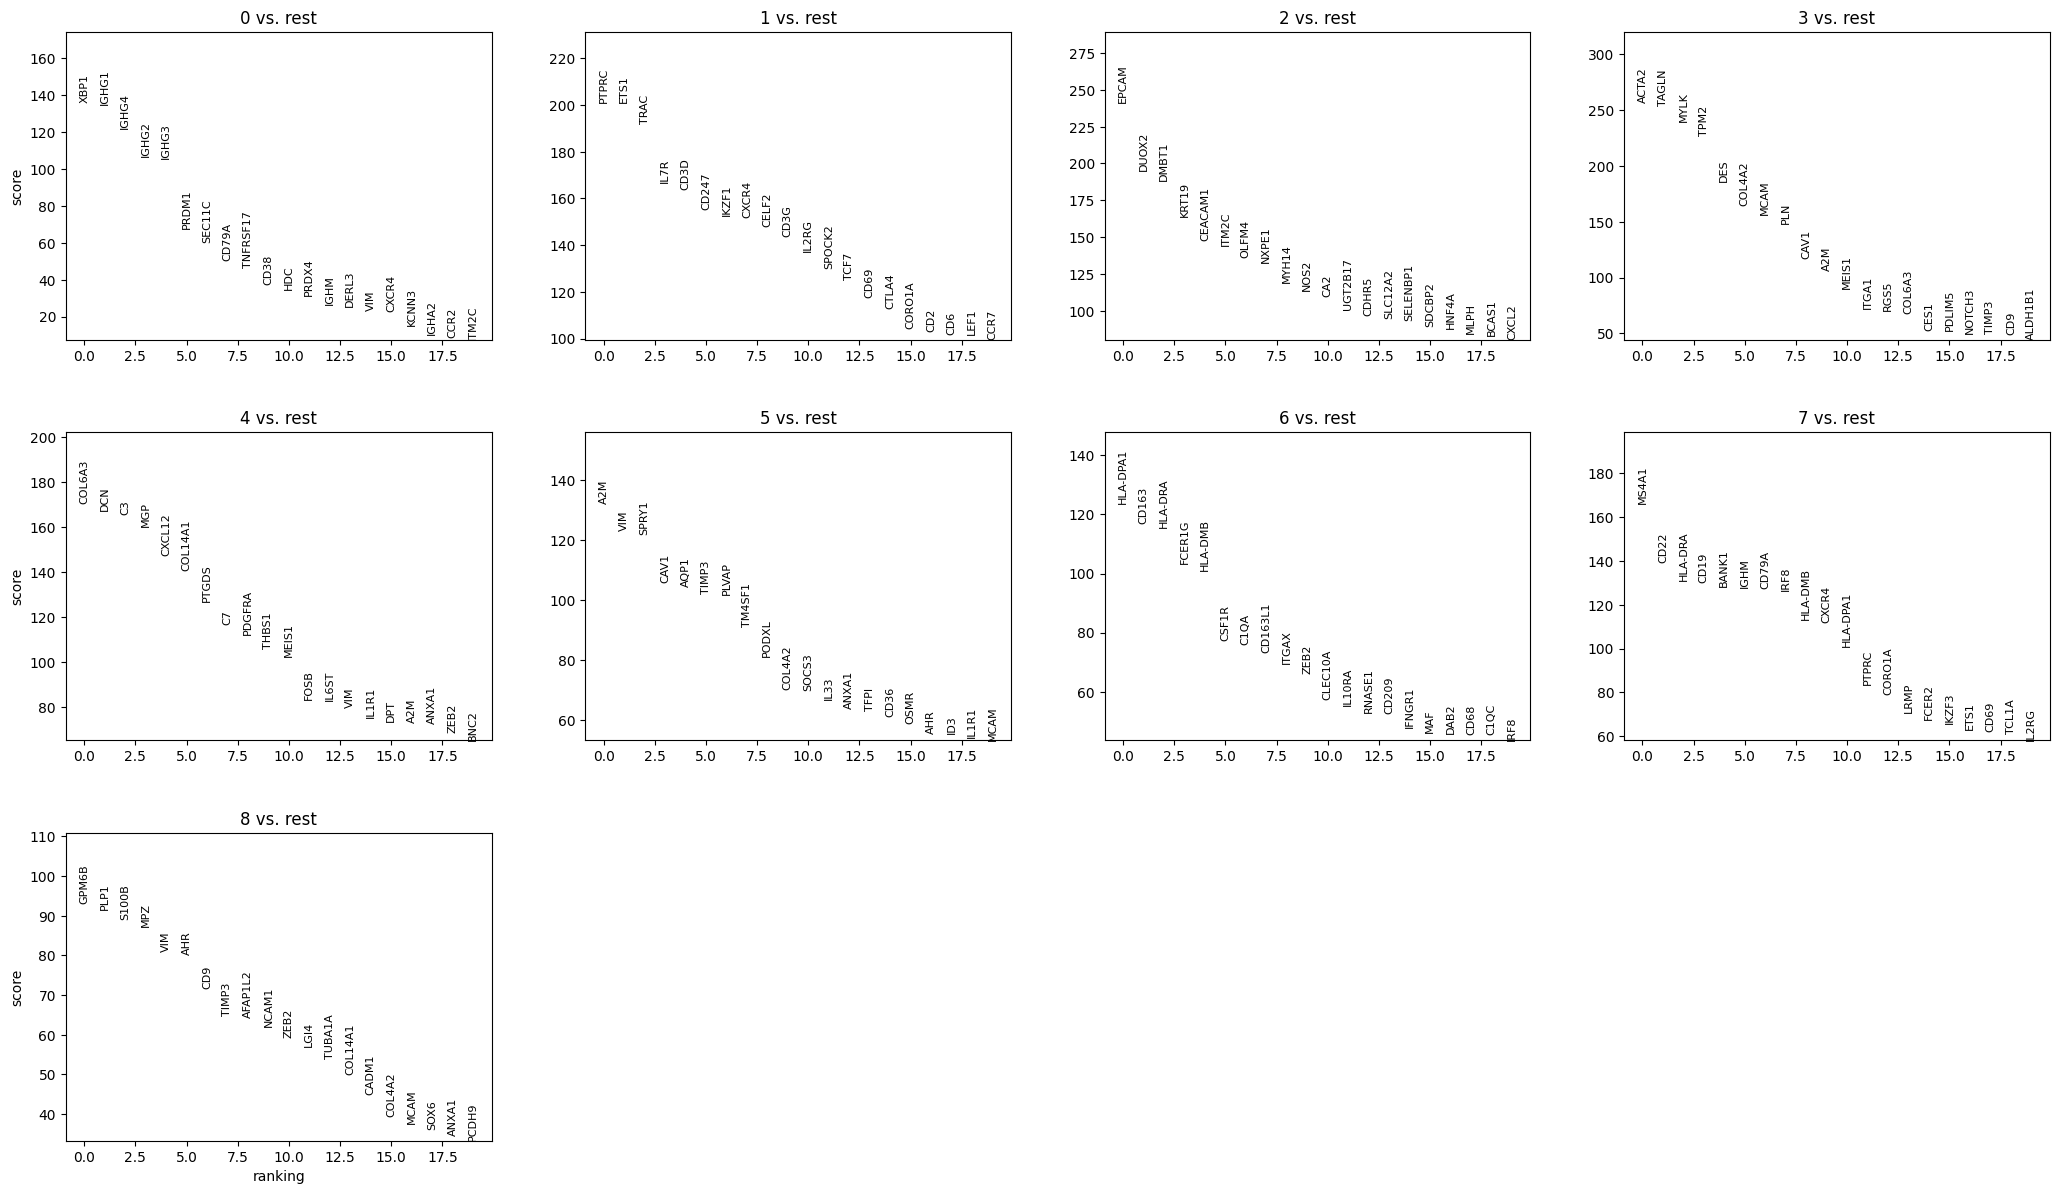

In [ ]:
# Marker genes
sc.tl.rank_genes_groups(adata, 'leiden_0.2', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

Figure 1.4 The above figure shows the ranked gene groups

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_0.2']`


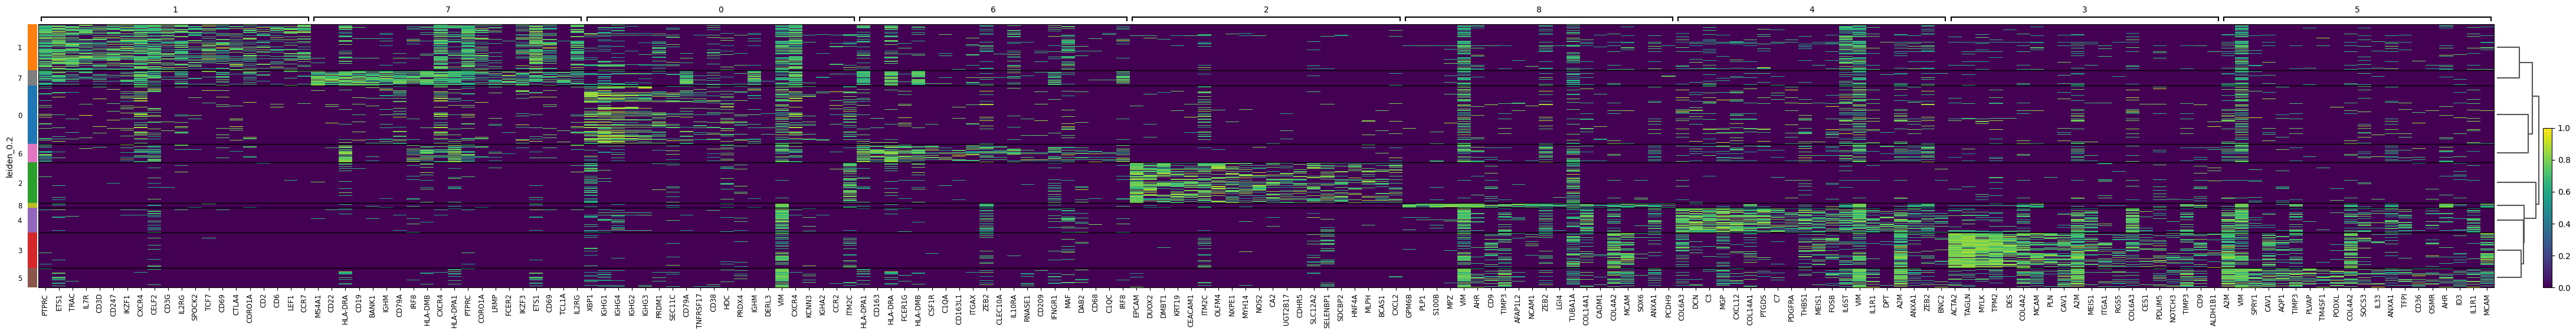

In [ ]:
# Plot a heatmap of the top marker genes
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=20,    # Number of top genes per cluster (can adjust)
    groupby='leiden_0.2',
    show_gene_labels=True,
    cmap='viridis',   # You can choose different colormaps
    standard_scale='var'  # Standardize the expression values per gene (makes it look better)
)

Figure 1.5 The above figure displays heatmap of the top marker genes

Let's characterize the cells!

In [ ]:
cell_type_dict = {"0": "Plasma cell", # XBP1, PRDM1
                  "1": "T cell", # PTPRC, IL7R, CD3D, CD247, IKZF1, CD3G, IL2RG, CD69, CTLA4, CD2, CD6, LEF1, and CCR7
                  "2": "Epithelial cell", #EPCAM, KRT19, DMBT1
                  "3": "Smooth muscle cell", #ACTA2, TAGLN, MYLK, TPM2, DES
                  "4": "Fibroblast/Stromal cell", # COL6A3, COL14A1, DCN, MGP, CXCL12
                  "5": "Endothelial cell", # A2M, TM4SF1, AQP1
                  "6": "Macrophages", #
                  "7": "B cell", #
                  "8": "Glial cell", #PLP1, S100B, GPM6B
                  }

We have now annotated the cells! We can now map the cluster annotation to the WSI to understand the spatial location of each cluster (cell type).

In [ ]:
# Create a new column 'cell_type' based on the 'leiden_0.2' cluster assignments
cluster_assignment_w_annotation = cluster_assignment.copy()
cluster_assignment_w_annotation['cell_type_0.2'] = cluster_assignment_w_annotation['leiden_0.2'].map(cell_type_dict)

# Display the updated DataFrame
cluster_assignment_w_annotation.head()

index leiden_0.5 leiden_0.2    cell_type_0.2
0    92          4          2  Epithelial cell
1    93          4          2  Epithelial cell
2    94          4          2  Epithelial cell
3    95          4          2  Epithelial cell
4    97          4          2  Epithelial cell

In [ ]:
cluster_assignment_w_annotation.to_csv('leiden_clusters_w_annotation.csv', index=False)

The following cell extracts the outcome of this clustering for every cell id in the WSI.

Note: The annotation above has not been integrated into the analysis below (above displayed clusters were generated using seed = 209). The below clustering is generated using truly random seed. For MS5, we will do similar visualization with the above cluster with cell type annotation!

In [ ]:
n_clusters = df_cell_cluster["leiden_0.2"].nunique()
df_cell_cluster.columns = ["Cell_id","leiden_0.5","leiden_0.2"]
df_cell_cluster["leiden_0.5"] = df_cell_cluster["leiden_0.5"].map(lambda x: x+1)
df_cell_cluster["leiden_0.2"] = df_cell_cluster["leiden_0.2"].map(lambda x: x+1)
print("The gene expression clustering produced ", n_clusters, " clusters")
df_cell_cluster.head()

The gene expression clustering produced  9  clusters


Cell_id  leiden_0.5  leiden_0.2
0       92           5           3
1       93           5           3
2       94           5           3
3       95           5           3
4       97           5           3

Then, we design a function to recove cluster-level cell mask for any patch in our WSI.  

In [ ]:
def get_cluster_mask(coord):
  patch_array = np.array(he_segm_patches_dataset[coord]).squeeze(-1)
  cells_ids_in_patch = np.unique(patch_array[patch_array> 0])
  cell_cluster_in_patch = df_cell_cluster[df_cell_cluster["Cell_id"].isin(cells_ids_in_patch)]
  cell_cluster_mask = np.zeros_like(patch_array)

  for i in tqdm.tqdm(range(len(cell_cluster_in_patch))):
    cell_cluster_mask[patch_array == cell_cluster_in_patch.iloc[i]["Cell_id"]] = cell_cluster_in_patch.iloc[i]["leiden_0.2"]
  return cell_cluster_mask

In [ ]:
coords = list(he_segm_patches_dataset.keys())
test_cell_cluster_mask = get_cluster_mask(coords[0])

100%|██████████| 3831/3831 [00:04<00:00, 825.51it/s]


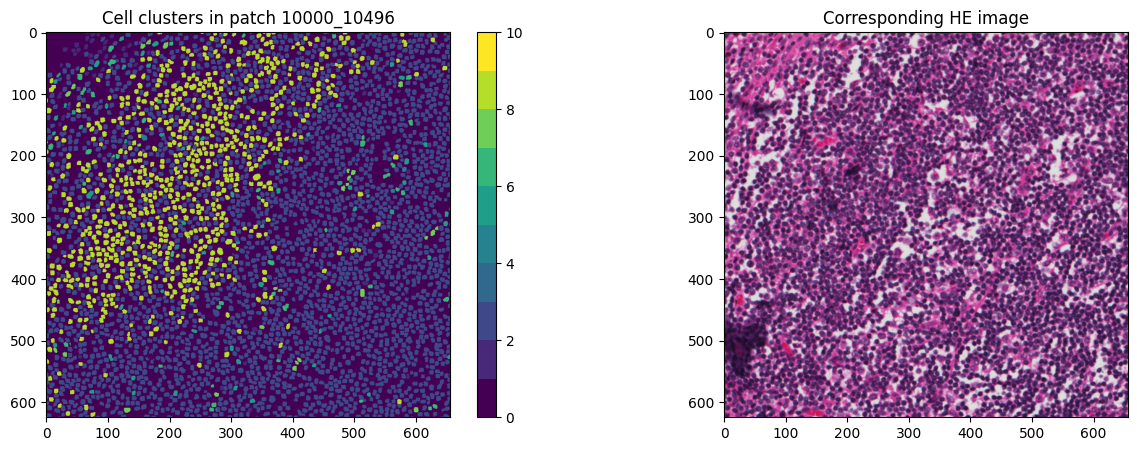

In [ ]:
discrete_viridids = plt.get_cmap("viridis", n_clusters+1) #go from 0 to n_cluster => n+1 levels
fig, ax = plt.subplots(1,2, figsize=(15,5))
small_cluster_img = ax[0].imshow(test_cell_cluster_mask, cmap = discrete_viridids, vmin = 0, vmax = n_clusters+1)
ax[0].set_title("Cell clusters in patch "+str(coords[0]))
fig.colorbar(small_cluster_img)
ax[1].imshow(he_array_saved[int(coords[0].split("_")[0]):int(coords[0].split("_")[0])+patch_size[0],int(coords[0].split("_")[1]):int(coords[0].split("_")[1])+patch_size[1],:])
ax[1].set_title("Corresponding HE image")
plt.show()

Figure 1.6 The above figure shows cell clusters in a tile and its corresponding H&E image

From the previous visualization we see that gene expression profiles in the image seem to heavily correlate with cell location. Although most nuclei look quite similar on the HE (right) image, we see that the cell cluster in regions of homogenous cell expression profile (mainly clusters 2 and 8). Let's take a step back and appreciate these patterns on larger scales.

In [ ]:
def coord_id_to_real(coord_key):
  coord_list = coord_key.split("_")
  return tuple(map(int, coord_list))

def coord_real_to_id(coord):
  return f"{coord[0]}_{coord[1]}"

Following our previous implementation, we extract a square with $n \times n$ contiguous patches (here $n = 3$).

In [ ]:
n_side_patches = 3

cell_cluster_mask_big = np.zeros((n_side_patches*patch_size[0], n_side_patches*patch_size[1]))
start_coord = "10000_9184"
start_real_coord = coord_id_to_real(start_coord)
for i in range(n_side_patches):
  for j in range(n_side_patches):
    coord_key = coord_real_to_id((start_real_coord[0] + i*patch_size[0], start_real_coord[1] + j*patch_size[1]))
    temp_local_patch = get_cluster_mask(coord_key)
    cell_cluster_mask_big[i*patch_size[0]:(i+1)*patch_size[0], j*patch_size[1]:(j+1)*patch_size[1]] = temp_local_patch

100%|██████████| 390/390 [00:00<00:00, 1557.31it/s]


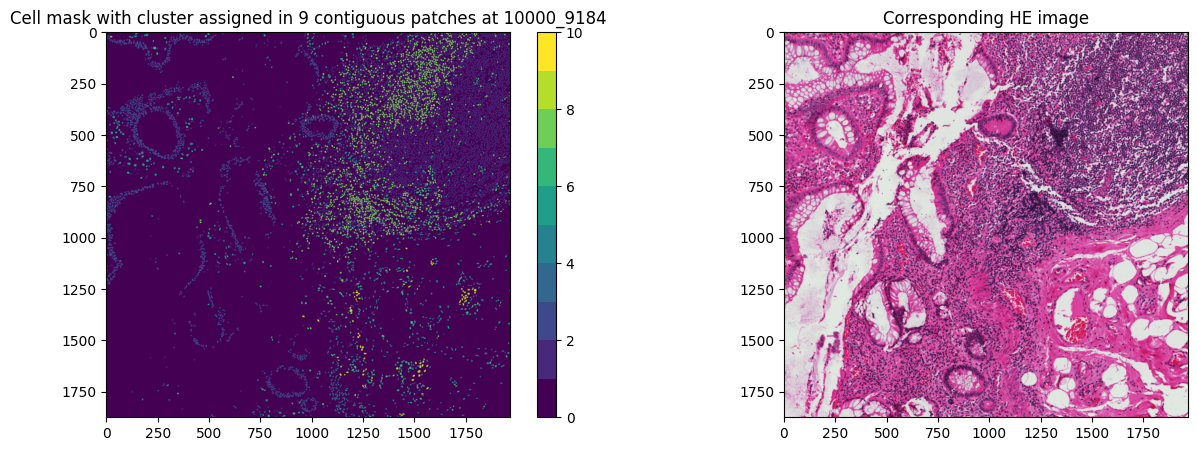

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
discrete_viridis = plt.get_cmap("viridis", n_clusters+1)
cell_cluster_im = ax[0].imshow(cell_cluster_mask_big, cmap = discrete_viridis, vmin = 0, vmax = n_clusters+1)
ax[0].set_title("Cell mask with cluster assigned in " +str(n_side_patches**2)+" contiguous patches at "+str(start_coord))
fig.colorbar(cell_cluster_im)
ax[1].imshow(he_array_saved[start_real_coord[0]:start_real_coord[0]+n_side_patches*patch_size[0],start_real_coord[1]:start_real_coord[1]+n_side_patches*patch_size[1],:])
ax[1].set_title("Corresponding HE image")
plt.show()

Figure 1.7 The above figure shows cell mask with cluster assignments and its corresponding H&E image

From a broader perspective, we also see that cells cluster in different gene expression regions. Concentric tissue structures appear to belong to gene expression cluster 2, while cell clusters 7 and 1 seem to distribute more evenly across parts of the tissue in the upper right corner of the image. This is not surprising, as gene expression profiles are most likely cell-type and tissue-type specific. Concentric structures across the image look like blood vessels cut in half in the pathology slice and are likely representative of cells belonging to the same cell type, therefore probably expressing similar gene expression profiles. We see here that the higher level organization of cells within the tissue can be an important factor for gene expression prediction. This sheds an interesting light on the role that a spatial context-aware model such as a Vision Transformer could play in predicting gene expression profiles across WSIs.

To stress this even more, we take a look at the different cell locations across each gene expression cluster.

In [ ]:
print(cell_cluster_mask_big[cell_cluster_mask_big == 9].sum(), df_cell_cluster[df_cell_cluster["leiden_0.2"] == 9].shape[0])
print("Cluster 9 is not present in the current image!")

0.0 4375
Cluster 9 is not present in the current image!


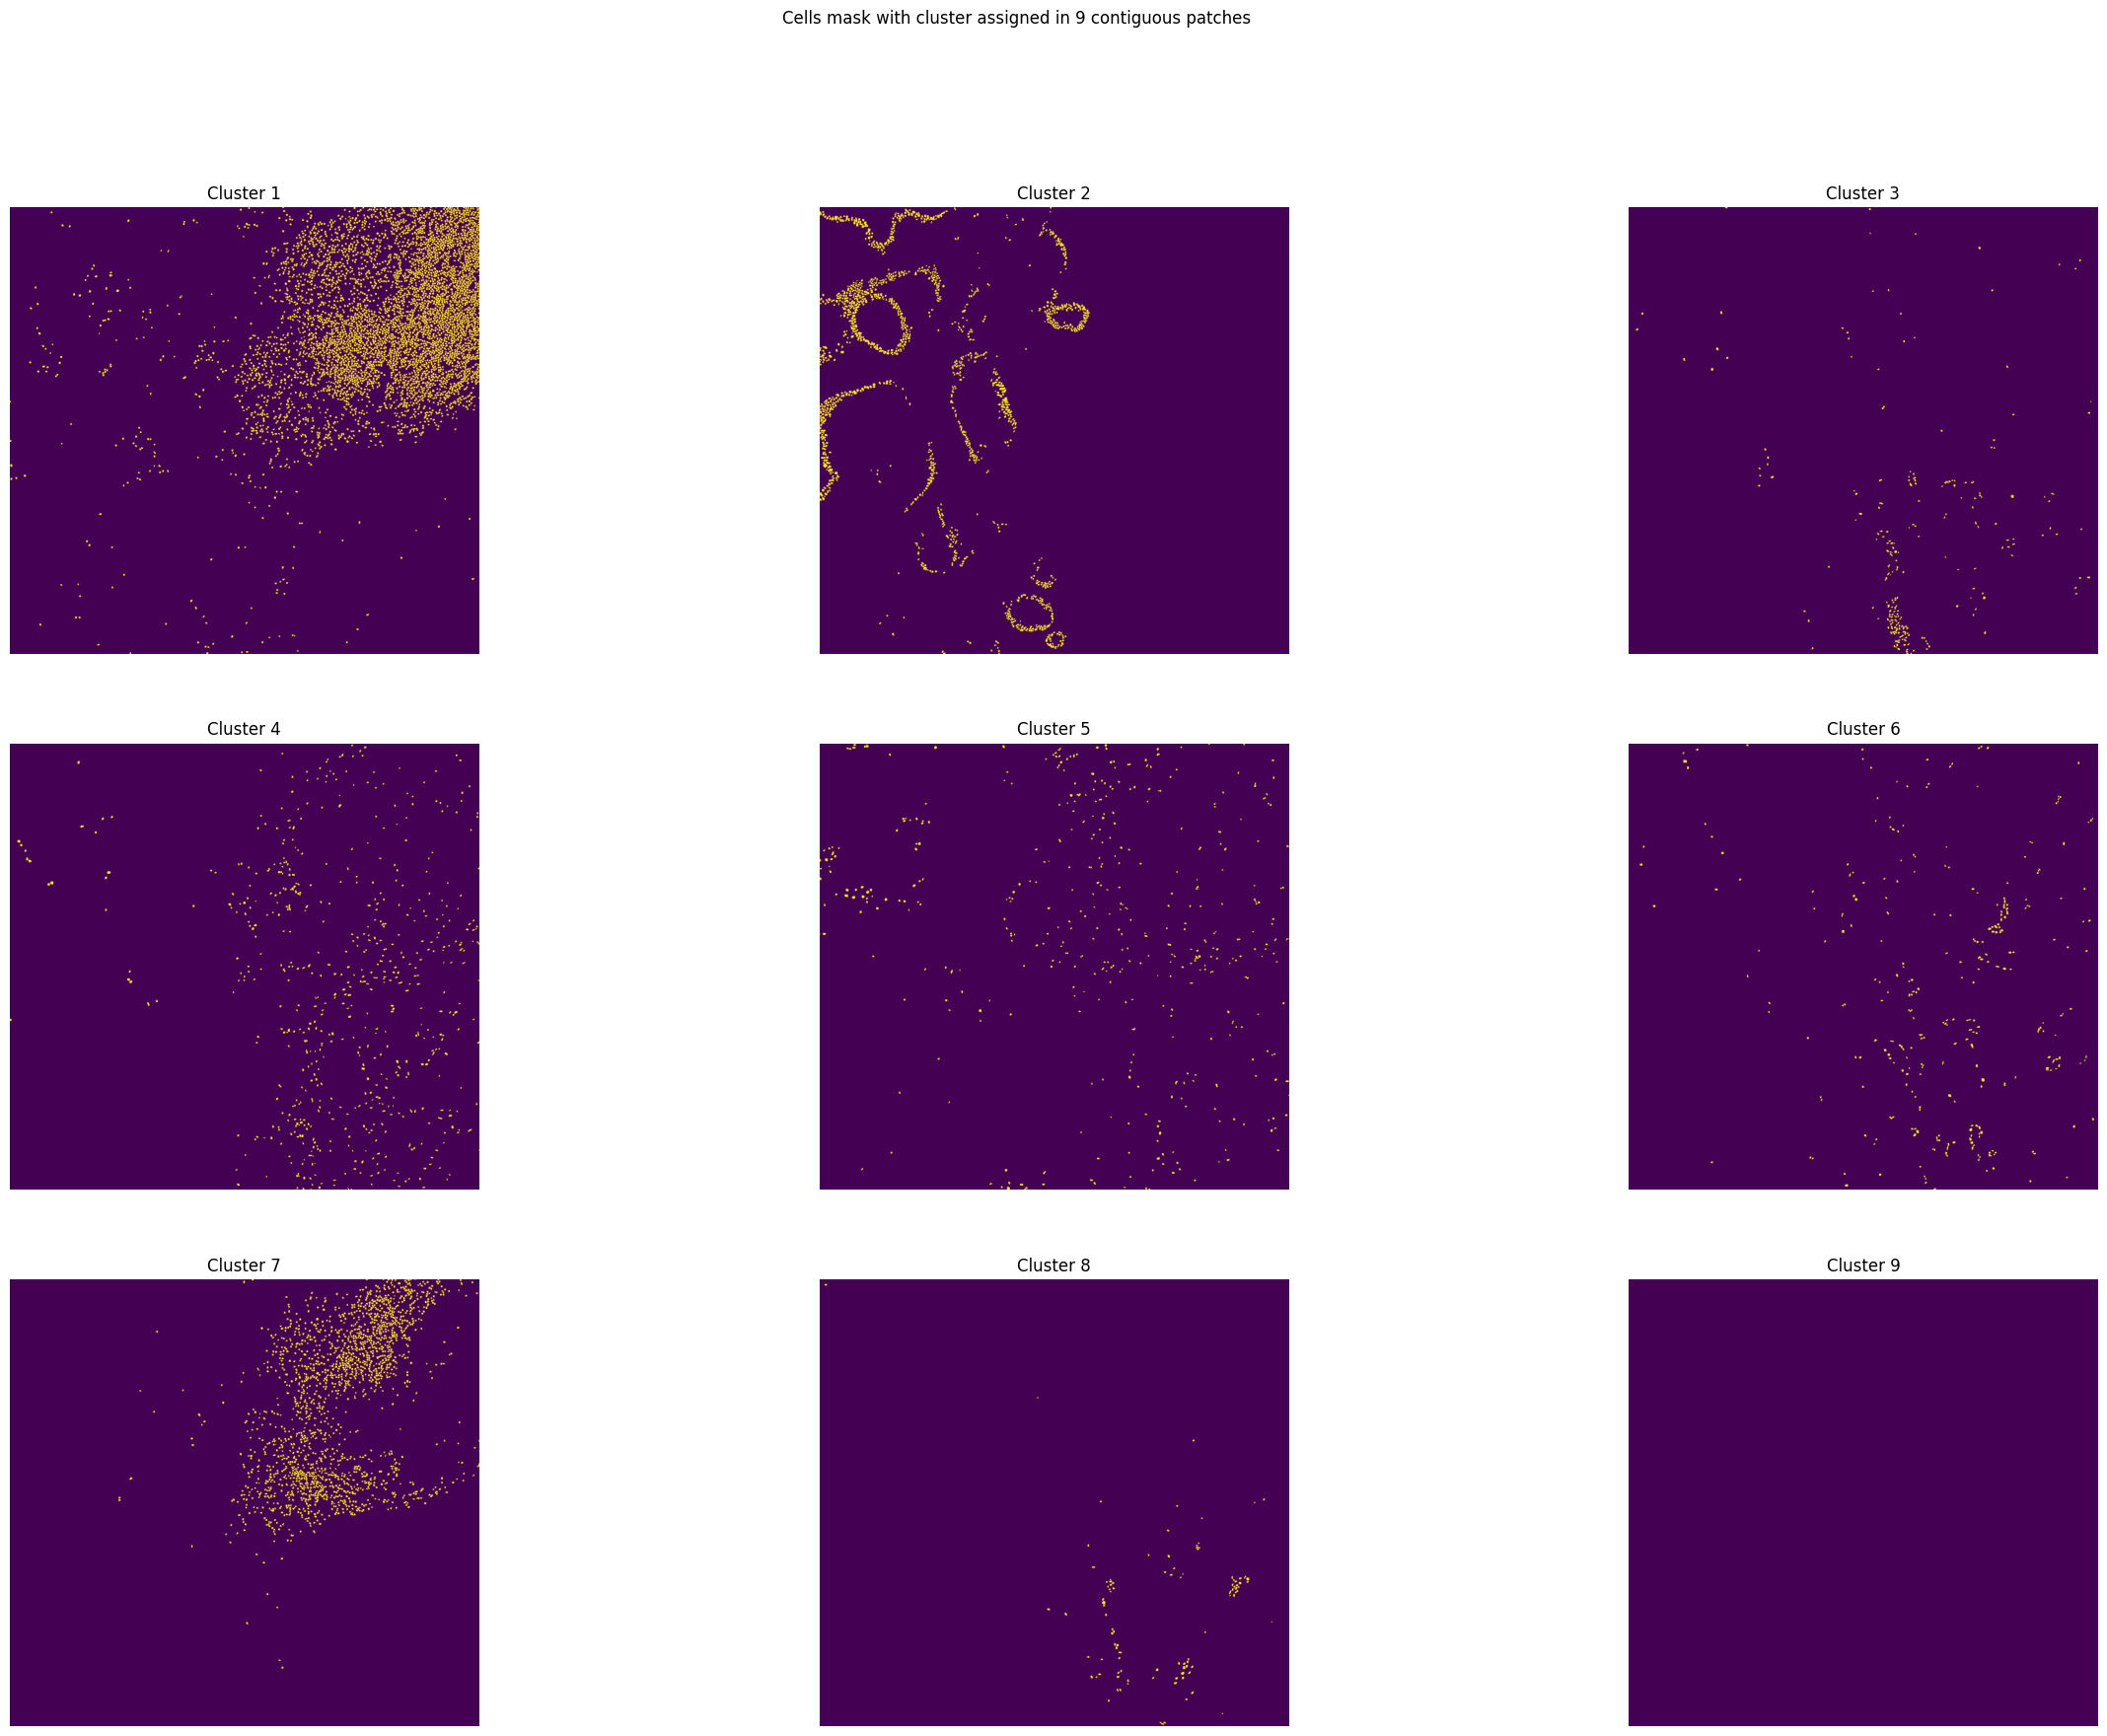

In [ ]:
discrete_viridids = plt.get_cmap("viridis", n_clusters)
fig, ax = plt.subplots(3,3, figsize=(30,20))
for i in range(3):
  for j in range(3):
    cluster_id = 1+i*3 + j
    cell_cluster_mask_big_cluster_id = (cell_cluster_mask_big == cluster_id)*cell_cluster_mask_big
    ax[i,j].imshow(cell_cluster_mask_big_cluster_id, cmap= "viridis")
    ax[i,j].set_title(f"Cluster {cluster_id}")
    ax[i,j].axis('off')

fig.suptitle("Cells mask with cluster assigned in " +str(n_side_patches**2)+" contiguous patches")
plt.show()

Figure 1.8 The above image shows cell mask with cluster assignments in 9 contiguous patches

Once again, we notice that each cell cluster seems to occupy a precise position in the WSI, depending on the corresponding cell types and cell organizations into structures. Cluster 7 and 1 seem to locate in neighboring regions (in the upper right corner of the image). Cluster 2 seems to characterize concentric blood vessel structure in the tissue. Cluster 8 spatial distribution is much more contained to a smaller area. Cluster 4,5 and 6 seem to be freely distributed across the WSI.

Next, one can wonder what could be a reasonable lower boundary to measure cell spatial interactions. Without loosing too much generality, one can compute the typical size of cell by approximating each cell with a disk in the microscope observation plane. The typical diameter of any given cell can be computed with the area of the corresponding cell id in the cells segmentation mask:
$$D \approx 2\times \sqrt{\frac{Area}{\pi}}$$

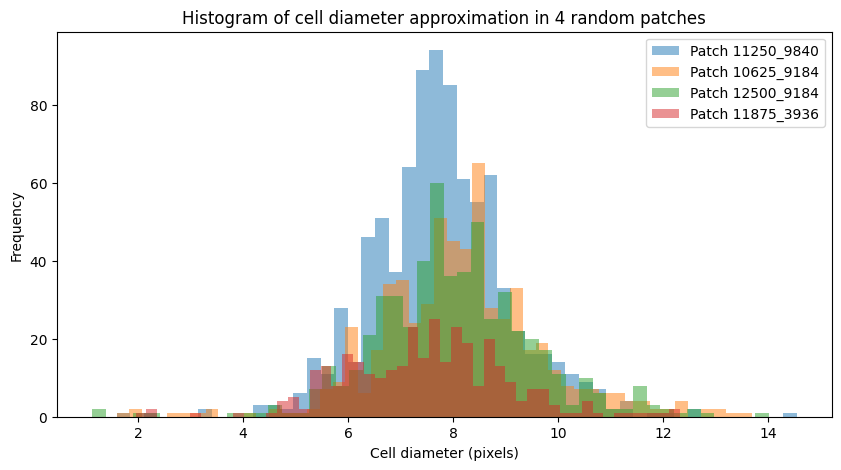

In [ ]:
#shortest scale of spatial correlation = cell
def compute_cell_diameter(coord):
  patch_array = np.array(he_segm_patches_dataset[coord]).squeeze(-1)
  cells_ids_in_patch = list(np.unique(patch_array[patch_array> 0]))
  cell_area = np.zeros(len(cells_ids_in_patch))
  for i,id in enumerate(cells_ids_in_patch):
    cell_area[i] = np.sum(patch_array == id)
  cell_diameter = 2*np.sqrt(cell_area/np.pi)
  return cell_diameter

rd_indices = list(np.random.randint(0,len(coords), 4))
cell_dimameters = [compute_cell_diameter(coords[i]) for i in rd_indices]
plt.figure(figsize=(10, 5))
for i in range(4):
  plt.hist(cell_dimameters[i], bins = 50, label = f"Patch {coords[rd_indices[i]]}", alpha = 0.5)
plt.xlabel("Cell diameter (pixels)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Histogram of cell diameter approximation in 4 random patches")
plt.show()

Figure 1.9 The above figure shows the histogram of cell diameter in 4 random patches

The distribution of cell diameters seems to be mostly unimodal, with no cells larger than 14 pixels.

**As a summary of this section**, we conclude that:
> 1. Gene expression profile meaningfully correlate with spatial cell distribution inside the image.
> 2. Our EDA puts in perspective relevant biological and physilogical spatial clusters of similar gene expression profiles inside the WSI across multiple levels of structural organization.
> 3. This set of gene-space correlations indicates that our model should access multiple levels of visual context in order to meaningfully predict gene expression profiles across the WSI.

**As a result**, we make the following implementation choices:
> 1. Keep resorting to image patchification, to help a model extract relevant features from local cell spatial distribution.
> 2. Use a pathology foundational image model (see Proposed pipeline for details) to extract biologically relevant features from spatial context in the WSI.
> 3. When using a visual tokenization approach, token dimensions should not be smaller than the typical diameter of a cell. An heuristic argument shows that $16\times 16$ visual tokens (as the ones produced by a ViT tokenizer) should work perfectly!

# Model Flowchart

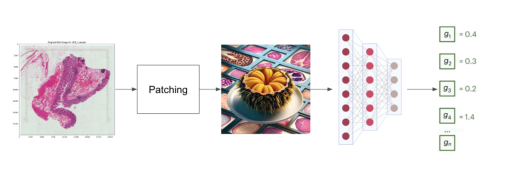

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('./drive/MyDrive/209B/model_flowchart_209.png')
plt.imshow(img)
plt.axis('off')
plt.show()

Figure 2. The above figure shows flowchart of our pipeline

# Decision to change our prediction task
Originally, as defined by "crunch 1" of the hackathon challenge from which we took the data from, the goal was to predict the expression level of 460 genes at the single cell level, "test cells" were given which we can provide prediction and compare against a benchmark on the competition website (similar to our kaggle challenges), while actual performance is evaluated on a held out set. With this goal in mind, during the course of MS3 and MS4, we consistantly observed that our model was unable to 1) extract meaningful features for the task and 2) unable to learn, which we concluded from the following observations
- We began by using mse loss, which is standard for this task. During training, models reduced loss by at most 1e-3, and plateaus at 5th epoch
- We couldn't get our models to overfit
- Using a distributional loss in addition to the mse loss does not help the model learn
- In all cases (ResNet50 + MLP, UNI2 + MLP), we consistantly observed a negative R2, and a pearson / spearman close to 0

For clarity and conciseness we omit the prior results. After receiving guidance and feedback from Tong Ding during our meeting on 5/7, we decided to change our task slightly. The motivation is summarized as below:
- The single cell transcriptome is an inherently hard task. High sparsity holds both true biological signal and noise.
- Edge cases could collude with learning. Consider the case where two neighboring cells with completely different cell states sharing almost identical patch information. 

As a result, the report from this point on focuses on predicting the average expression of all cells in a given patch.

# Modeling Approach

For this project, we aim to predict patch level gene expression from local histology by systematically investigating the influence of surrounding morphological context. Our pipeline begins with patchifying the whole-slide images (WSIs) into square patches. We aim to experiment with varying levels of contextual information, but for the purposes of this notebook we are going to start with 200x200 pixels.

### Overview: Patch-level embedding and prediction
As ViTs are flexible to input size, we will use pretrained pathology-specific ViT model — specifically UNI-2 — for patch embedding. UNI, based on ViT-Large, outputs 1024-dimensional embeddings; and UNI-2, based on ViT-Giant, outputs 1536-dimensional embeddings. In the patch-level approach, each entire resized patch (regardless of its original extracted size) was processed through the ViT to yield a single vector embedding representing the patch as a whole.

For predicting gene expression from these patch embeddings, we used a shallow multi-layer perceptron (MLP) to model the relationship between patch embedding and the corresponding cell's gene expression profile. A typical MLP architecture will project the input embedding (e.g., 768, 1024, or 1536 dimensions) through two or three hidden layers with ReLU activations. For example, the network may consist of a 512-unit layer followed by a 256-unit layer before outputting predictions for 460 target genes. The models minimize mean squared error (MSE) between predicted and log1p-transformed true expression values, stabilizing variance due to the heavy-tailed distribution of RNA counts.

Cells will be randomly split into training-validation-testing sets to ensure fair evaluation without information leakage. Model performance will be assessed primarily via Pearson correlation coefficients and R2 between predicted and observed expression profiles. For all model training we used pytorch for maximized customizability

### Patching (Data processing)
We have a total of 8 WSI images with paired single cell expression data. One of them contained no cell ids (DC1, supposedly held out). For each of the remaining 7 slides, we first divide the image into 224z224 pixel large patches. For each patch, we record a list of cell ids whose centroid is located within the patch boundary. We then took the patch boundary to crop out the corresponding image patches and saved as a PIL image, while at the same time taking the list of cell ids for each patch to obtain an average expression for each of the 460 genes across all cells witin the patch. These steps are done outside of this notebook using a script located at [src/data/patch_process.py](https://github.com/harrlol/gutinstinct/blob/main/src/data/patch_process.py), with the resulting data object saved as a pickle file for each image, which we load into the environment below. 

In [9]:
# load in pkl files
all_patches = []
for filename in os.listdir(osp.expanduser(DATA_PATH)):
    if filename.endswith('.pkl'):
        image_id = re.sub(r'^patch_to_expr_', '', os.path.splitext(filename)[0])
        filepath = os.path.join(osp.expanduser(DATA_PATH), filename)
        with open(filepath, 'rb') as f:
            patch_list = pickle.load(f)
            for patch in patch_list:
                patch['image_id'] = image_id
                all_patches.append(patch)

### Load data, split

We proceed with a train:val:test = 7:1.5:1.5 split. We manually stratify by image_id because we expect slightly different pathological features present in each slide and therefore potentially different disease mechanism at play. This means that the model should be able to learn and generalize better as it benefits from this controlled diversity. We unfortunately did not do an ablation study on the straitification, which would be an important future direction.

In [10]:
random.seed(SEED)
patch_train, patch_val, patch_test = [], [], []
expr_train, expr_val, expr_test = [], [], []

# set up splits
# we will stratify by image_id
train_prop = 0.7
val_prop = 0.15
test_prop = 0.15

image_id_to_patches = {}
for patch in all_patches:
    image_id = patch['image_id']
    if image_id not in image_id_to_patches:
            image_id_to_patches[image_id] = []
    image_id_to_patches[image_id].append(patch)

for patch_list in image_id_to_patches.values():
    # get total patch number for current image_id
    n = len(patch_list)

    # shuffle the patches
    random.shuffle(patch_list)

    # get the split indices
    n_train = int(n * train_prop)
    n_val = int(n * val_prop)
    n_test = n - n_train - n_val

    train = patch_list[:n_train]
    val = patch_list[n_train:n_train + n_val]
    test = patch_list[n_train + n_val:]

    # Separate each into X (pil) and y (expr)
    patch_train.extend([p['pil'] for p in train])
    expr_train.extend([p['expr'] for p in train])

    patch_val.extend([p['pil'] for p in val])
    expr_val.extend([p['expr'] for p in val])

    patch_test.extend([p['pil'] for p in test])
    expr_test.extend([p['expr'] for p in test])

print(f"Train: {len(patch_train)}, Val: {len(patch_val)}, Test: {len(patch_test)}")

Train: 12597, Val: 2697, Test: 2707


### Brief EDA

Below we show some plots and stats for image UC6_I after the above processing steps. Trends are comparable across images. 

Processing ~/hl/ac109_project/raw/UC6_I.zarr/UC6_I.zarr

HE Nucleus Mask of dimension: (20000, 20992)

Number of cells in this slide: 308924

Number of patches: 3703

Patch size: 224

Minimum number of cells in a patch: 1

Maximum number of cells in a patch: 523

Average number of cells in a patch: 83.425

Number of patches with valid images: 3703

Max average expression: 0.11787694692611694

Min average expression: 0.04020948335528374

Deleted 462 patches with no cells containing expression information

Number of remaining patches (which has valid expression data): 3241

Number of patches with at least 10 cells: 46

Number of patches with at least 10 cells: 2459

Number of patches with at least 100 cells: 827

Finished processing ~/hl/ac109_project/raw/UC6_I.zarr/UC6_I.zarr


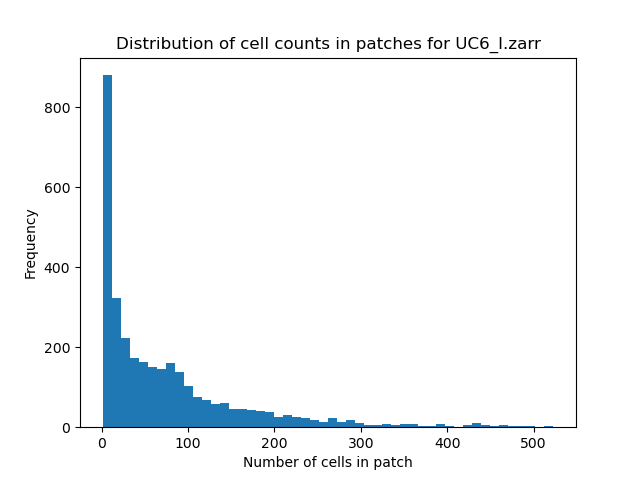

In [31]:
## cell_counts_per_patch_UC6_I.zarr.png
with open(osp.expanduser("~/hl/gutinstinct/data/plots/cell_counts_per_patch_UC6_I.zarr.png"), "rb") as f:
    encoded = base64.b64encode(f.read()).decode("utf-8")

HTML(f'<img src="data:image/png;base64,{encoded}">')



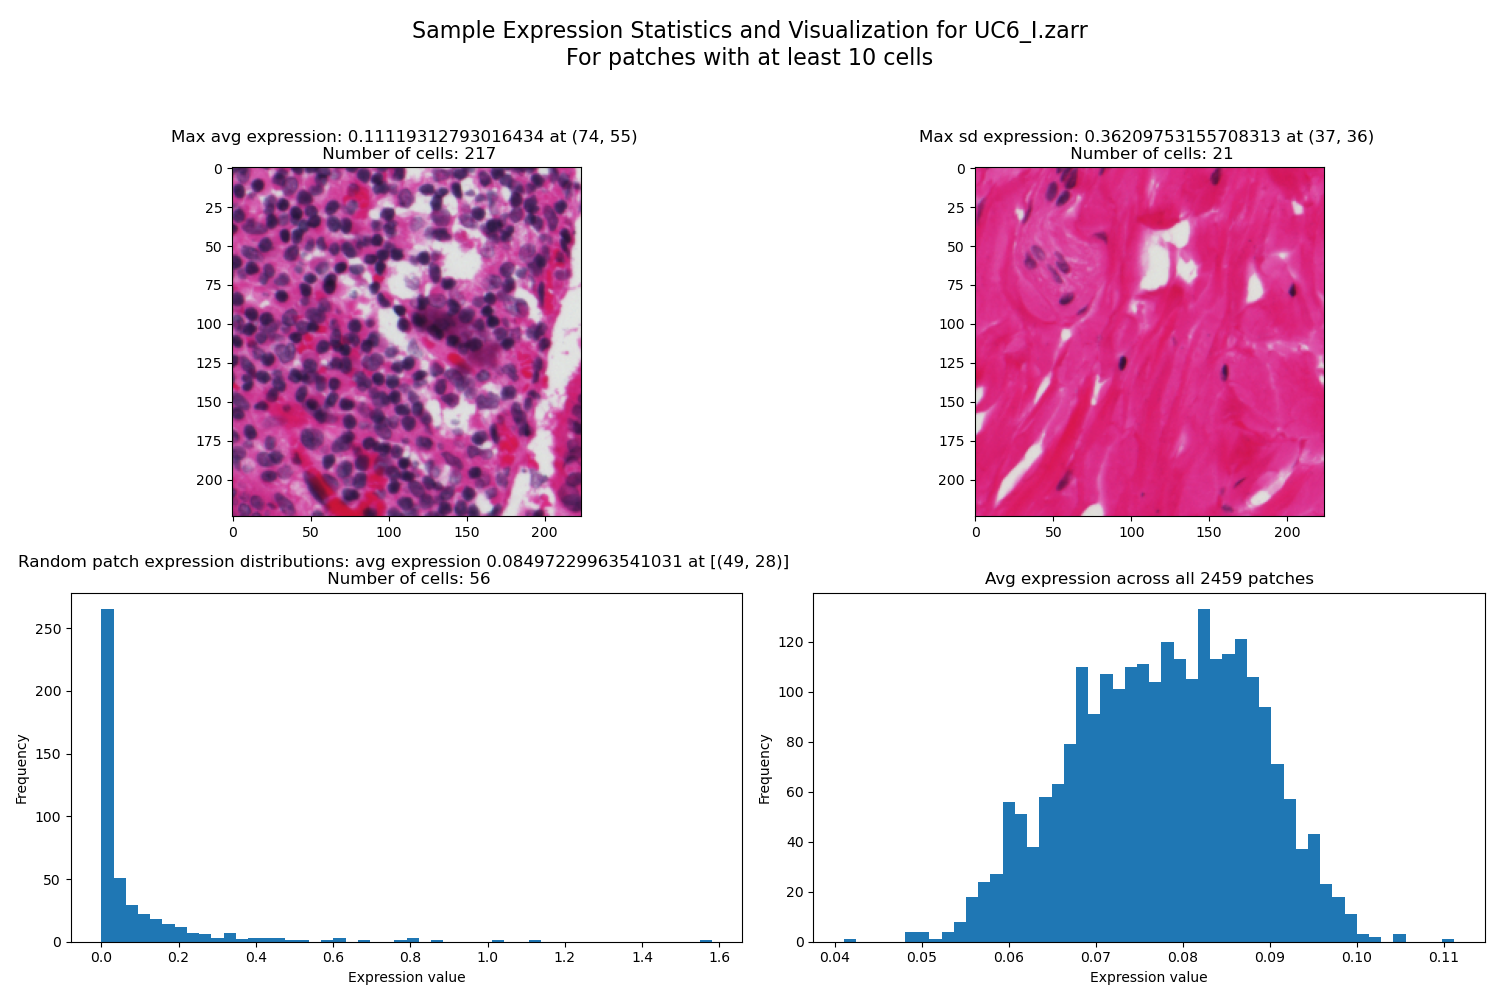

In [32]:
## sample_expression_viz_UC6_I.zarr.png
with open(osp.expanduser("~/hl/gutinstinct/data/plots/sample_expression_viz_UC6_I.zarr.png"), "rb") as f:
    encoded = base64.b64encode(f.read()).decode("utf-8")

HTML(f'<img src="data:image/png;base64,{encoded}">')



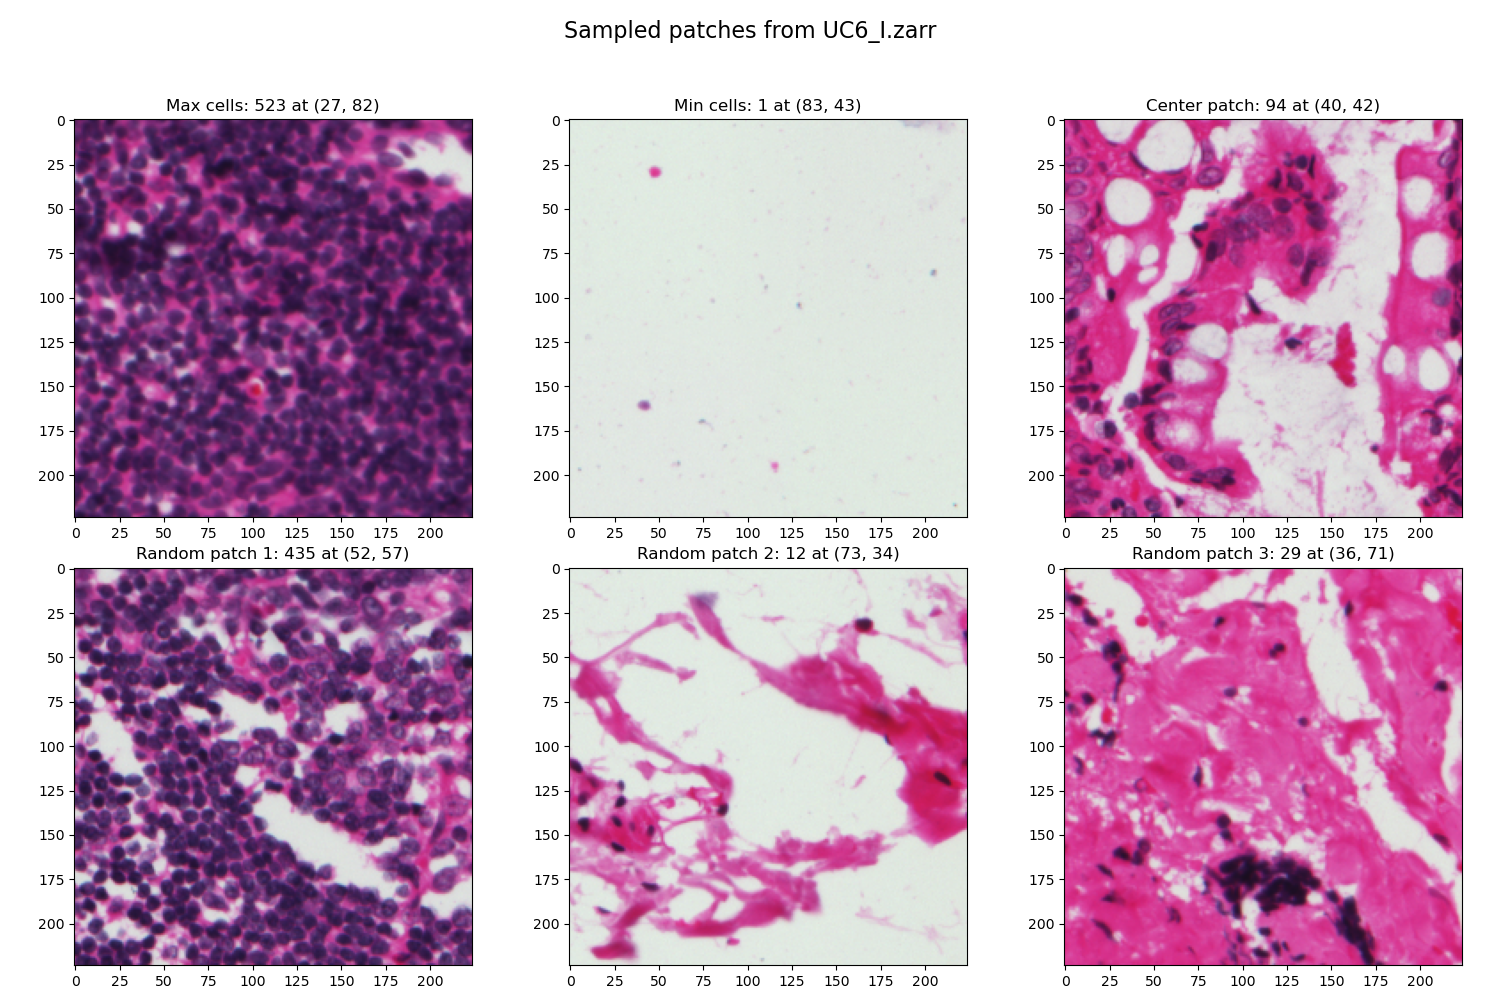

In [34]:
## sample_patches_viz_UC6_I.zarr.png
with open(osp.expanduser("~/hl/gutinstinct/data/plots/sample_patches_viz_UC6_I.zarr.png"), "rb") as f:
    encoded = base64.b64encode(f.read()).decode("utf-8")

HTML(f'<img src="data:image/png;base64,{encoded}">')

### Training setup

For all model training, we use AdamW with 0.001 weight decay to avoid overfitting and increase generalizability. While the latter is not a particular big problem in comparison (thanks to our stratification), during initial training we did observe significant overfitting. In addition, we also added numerous dropouts in the baseline for the same purpose -- and for later UNI + MLP setups as well, where applicable. For all trianing, we used 100 epochs with ealry stopping with patience=10 (5 for finetuning because of time constraint), adaptable learning rate with initial at 1e-3. Early stopping allows us to automatically retrieve the best performing model before it starts to overfit by monitoring validation loss, and scheduler allows us to gradually decrease learning rate as we approach a minima to avoid overshooting. In addition to mse loss, we also use R2 and pearson to evaluate our model performance. These two metrics are commonly used by the field for expression prediction. Intuitively, it compares "how far off is the predicted cell state to the ground truth cell state" by placing the two inside a shared high dimensional space and calculating the distance between the two points, and is therefore suitable for our task here. 

### Baseline: CNN + Linear

For our baseline we used a CNN architecture with a single linear layer as its prediction head. The mode is 3 layers deep in CNN, and detailed configs of the model is recorded [here](https://github.com/harrlol/gutinstinct/blob/main/src/models/baseline.py) \

Below, we create data loaders to feed into this model, using torch vision's transform for PIL image normalization / scaling, and common pipeline for tensor creation and dataloaders. 

In [11]:
# process images, pair with expression vectors
transform = transforms.ToTensor()

# transform pil to tensor and normalize /255, tensorize expression vectors
patch_tensors_train = [transform(patch) for patch in patch_train]
expr_tensors_train = [torch.tensor(e, dtype=torch.float32) for e in expr_train]
patch_tensors_val = [transform(patch) for patch in patch_val]
expr_tensors_val = [torch.tensor(e, dtype=torch.float32) for e in expr_val]
patch_tensors_test = [transform(patch) for patch in patch_test]
expr_tensors_test = [torch.tensor(e, dtype=torch.float32) for e in expr_test]

# assemble
train_dataset = TensorDataset(torch.stack(patch_tensors_train), torch.stack(expr_tensors_train))
val_dataset = TensorDataset(torch.stack(patch_tensors_val), torch.stack(expr_tensors_val))
test_dataset = TensorDataset(torch.stack(patch_tensors_test), torch.stack(expr_tensors_test))

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/home/b-evelyntong/miniconda3/envs/gutinstinct/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.0253, Val Loss: 0.0236, R2: 0.4763, Pearson: 0.7061
Epoch 2/100, Train Loss: 0.0208, Val Loss: 0.0221, R2: 0.5191, Pearson: 0.7274
Epoch 3/100, Train Loss: 0.0200, Val Loss: 0.0212, R2: 0.5448, Pearson: 0.7431
Epoch 4/100, Train Loss: 0.0196, Val Loss: 0.0208, R2: 0.5565, Pearson: 0.7480
Epoch 5/100, Train Loss: 0.0194, Val Loss: 0.0207, R2: 0.5576, Pearson: 0.7521
Epoch 6/100, Train Loss: 0.0191, Val Loss: 0.0201, R2: 0.5738, Pearson: 0.7577
Epoch 7/100, Train Loss: 0.0189, Val Loss: 0.0199, R2: 0.5781, Pearson: 0.7610
Epoch 8/100, Train Loss: 0.0187, Val Loss: 0.0198, R2: 0.5808, Pearson: 0.7628
Epoch 9/100, Train Loss: 0.0187, Val Loss: 0.0202, R2: 0.5704, Pearson: 0.7609
Epoch 10/100, Train Loss: 0.0185, Val Loss: 0.0200, R2: 0.5735, Pearson: 0.7631
Epoch 11/100, Train Loss: 0.0185, Val Loss: 0.0200, R2: 0.5758, Pearson: 0.7630
Epoch 12/100, Train Loss: 0.0183, Val Loss: 0.0195, R2: 0.5863, Pearson: 0.7670
Epoch 13/100, Train Loss: 0.0182, Val Loss: 0.019

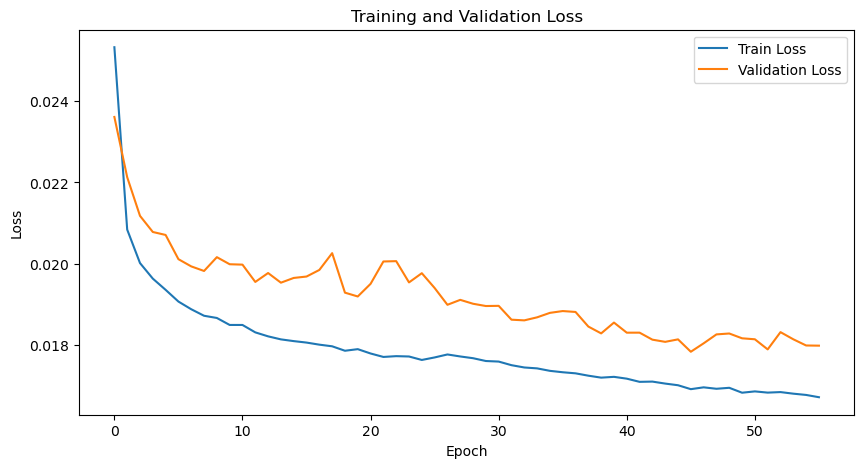

In [5]:
# train the model
model_baseline = CNNPlusLinear()

model_baseline, metrics_baseline = trainer.train_model(
    model_baseline,
    train_loader,
    val_loader,
    compute_r2,
    compute_pearsonr,
    num_epochs=100,
    lr=1e-3,
    weight_decay=0.001,
    patience=10,
    save_plot_path='baseline_loss_plot.png',
    criterion=nn.MSELoss(),
    scheduler_patience=5,
    scheduler_factor=0.5,
    verbose=True,
)

In [43]:
# evaluate baseline on test set
model_baseline.eval().to('cuda')
running_test_loss = 0.0
y_preds = []
y_trues = []
criterion = nn.MSELoss()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
        y_pred = model_baseline(x_batch)
        loss = criterion(y_pred, y_batch)
        running_test_loss += loss.item()

        y_preds.append(y_pred.cpu().numpy())
        y_trues.append(y_batch.cpu().numpy())

    test_loss = running_test_loss / len(test_loader)
    y_preds = np.concatenate(y_preds, axis=0)
    y_trues = np.concatenate(y_trues, axis=0)
    r2_score = compute_r2(y_trues, y_preds)
    pearson_score = compute_pearsonr(y_trues, y_preds)
    print(f"Test Loss: {test_loss:.4f}, R2: {r2_score:.4f}, Pearson: {pearson_score:.4f}")

metrics_baseline['test_loss'] = test_loss
metrics_baseline['test_r2'] = r2_score
metrics_baseline['test_pearson'] = pearson_score

#Test Loss: 0.0173, R2: 0.6311, Pearson: 0.7948

Test Loss: 0.0173, R2: 0.6311, Pearson: 0.7948


### UNI Baseline

We thought to investigate whether a visual transformer called UNI, trained specifically on extracting useful features in H&E images, could produce useful features for our prediction task here. Notably, UNI was trained exclusively on image reconstruction tasks and distillation tasks, both in the imaging domain and is quite dissimilar to what we are doing here which is predicting another data modality. Theoretically, it would've internalized enough means to extract representations of an image to excel at a transfer learning task. Indeed, for this baseline section, we are evaluating UNI's zero shot ability at predicting gene expression using image features

For the uni model we took their default configurations on their [github repo](https://github.com/mahmoodlab/UNI)

In [12]:
## instantiate a uni model
timm_kwargs = {
   'img_size': 224,
   'patch_size': 32,
   'depth': 24,
   'num_heads': 24,
   'init_values': 1e-5,
   'embed_dim': 1536,
   'mlp_ratio': 2.66667*2,
   'num_classes': 0,
   'no_embed_class': True,
   'mlp_layer': timm.layers.SwiGLUPacked,
   'act_layer': torch.nn.SiLU,
   'reg_tokens': 8,
   'dynamic_img_size': True
  }
model_uni = timm.create_model("hf-hub:MahmoodLab/UNI2-h", pretrained=True, **timm_kwargs)
model_uni = model_uni.to('cuda')

# define new transform for uni
transform = create_transform(**resolve_data_config(model_uni.pretrained_cfg, model=model_uni))
model_uni.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(32, 32), stride=(32, 32))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): GluMlp(
        (fc1): Linear(in_features=1536, out_features=8192, bias=True)
        (act): SiLU()
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
    

In [13]:
# transform pil to tensor and normalize /255, tensorize expression vectors
patch_tensors_train = [transform(patch) for patch in patch_train]
expr_tensors_train = [torch.tensor(e, dtype=torch.float32) for e in expr_train]
patch_tensors_val = [transform(patch) for patch in patch_val]
expr_tensors_val = [torch.tensor(e, dtype=torch.float32) for e in expr_val]
patch_tensors_test = [transform(patch) for patch in patch_test]
expr_tensors_test = [torch.tensor(e, dtype=torch.float32) for e in expr_test]

# get features with uni
with torch.no_grad():
    patch_tensors_train = [model_uni(patch.unsqueeze(0).to('cuda')).cpu().squeeze(0) for patch in patch_tensors_train]
    patch_tensors_val = [model_uni(patch.unsqueeze(0).to('cuda')).cpu().squeeze(0) for patch in patch_tensors_val]
    patch_tensors_test = [model_uni(patch.unsqueeze(0).to('cuda')).cpu().squeeze(0) for patch in patch_tensors_test]
    
# assemble
train_dataset = TensorDataset(torch.stack(patch_tensors_train), torch.stack(expr_tensors_train))
val_dataset = TensorDataset(torch.stack(patch_tensors_val), torch.stack(expr_tensors_val))
test_dataset = TensorDataset(torch.stack(patch_tensors_test), torch.stack(expr_tensors_test))

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Here we pair an additional funneling MLP to transform the UNI-extracted features into the 460 gene expression predictions. This was decided after a little bit of experimenting with numbers of MLP layers and shape of the MLP, and eventually settled down on the architecture shown below. Dropout was added to mitigate overfitting.

/home/b-evelyntong/miniconda3/envs/gutinstinct/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.0185, Val Loss: 0.0174, R2: 0.6432, Pearson: 0.8026
Epoch 2/100, Train Loss: 0.0151, Val Loss: 0.0172, R2: 0.6462, Pearson: 0.8069
Epoch 3/100, Train Loss: 0.0146, Val Loss: 0.0171, R2: 0.6483, Pearson: 0.8092
Epoch 4/100, Train Loss: 0.0144, Val Loss: 0.0167, R2: 0.6615, Pearson: 0.8133
Epoch 5/100, Train Loss: 0.0142, Val Loss: 0.0165, R2: 0.6683, Pearson: 0.8195
Epoch 6/100, Train Loss: 0.0141, Val Loss: 0.0164, R2: 0.6685, Pearson: 0.8186
Epoch 7/100, Train Loss: 0.0139, Val Loss: 0.0164, R2: 0.6715, Pearson: 0.8206
Epoch 8/100, Train Loss: 0.0138, Val Loss: 0.0162, R2: 0.6745, Pearson: 0.8223
Epoch 9/100, Train Loss: 0.0138, Val Loss: 0.0162, R2: 0.6767, Pearson: 0.8232
Epoch 10/100, Train Loss: 0.0136, Val Loss: 0.0161, R2: 0.6790, Pearson: 0.8245
Epoch 11/100, Train Loss: 0.0135, Val Loss: 0.0160, R2: 0.6791, Pearson: 0.8258
Epoch 12/100, Train Loss: 0.0135, Val Loss: 0.0161, R2: 0.6815, Pearson: 0.8255
Epoch 13/100, Train Loss: 0.0134, Val Loss: 0.015

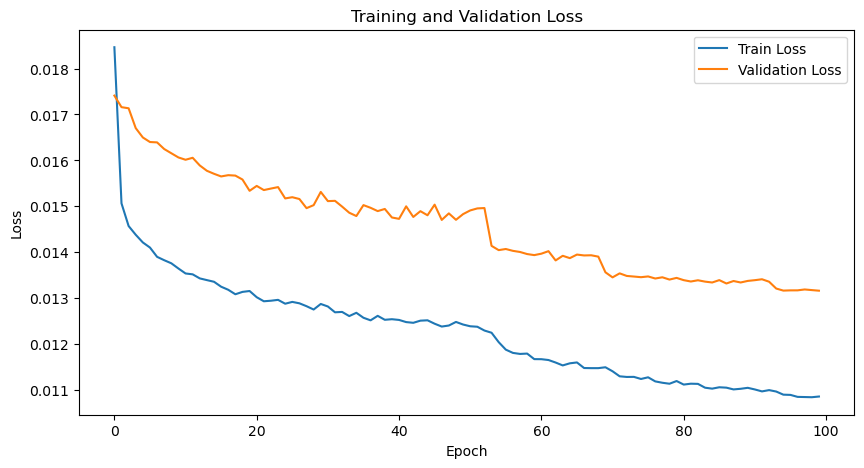

In [14]:
# train the model
model_uni_baseline = nn.Sequential(
    nn.Linear(1536, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 460),
).to('cuda')

model_uni_baseline, metrics_uni_baseline = trainer.train_model(
    model_uni_baseline,
    train_loader,
    val_loader,
    compute_r2,
    compute_pearsonr,
    num_epochs=100,
    lr=1e-3,
    weight_decay=0.001,
    patience=10,
    save_plot_path='uni_baseline_loss_plot.png',
    criterion=nn.MSELoss(),
    scheduler_patience=5,
    scheduler_factor=0.5,
    verbose=True,
)

In [15]:
# evaluate baseline on test set
model_uni_baseline.eval().to('cuda')
criterion = nn.MSELoss()
running_test_loss = 0.0
y_preds = []
y_trues = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
        y_pred = model_uni_baseline(x_batch)
        loss = criterion(y_pred, y_batch)
        running_test_loss += loss.item()

        y_preds.append(y_pred.cpu().numpy())
        y_trues.append(y_batch.cpu().numpy())

    test_loss = running_test_loss / len(test_loader)
    y_preds = np.concatenate(y_preds, axis=0)
    y_trues = np.concatenate(y_trues, axis=0)
    r2_score = compute_r2(y_trues, y_preds)
    pearson_score = compute_pearsonr(y_trues, y_preds)
    print(f"Test Loss: {test_loss:.4f}, R2: {r2_score:.4f}, Pearson: {pearson_score:.4f}")

metrics_uni_baseline['test_loss'] = test_loss
metrics_uni_baseline['test_r2'] = r2_score
metrics_uni_baseline['test_pearson'] = pearson_score

#Test Loss: 0.0133, R2: 0.7394, Pearson: 0.8577

Test Loss: 0.0124, R2: 0.7553, Pearson: 0.8677


### Finetuning UNI

Even though the UNI as it is showed strong performance off the bat, we were interested in seeing if we could further improve it. The idea is that the original task was entirely at the phenotypical / image level, not collecting information for the goal of predicting expression, so maybe the features extracted in the last layer aren't quite exactly what we need to get good expression prediction. So, below we finetune the last two blocks of the ViT (unfreeze the last two blocks of the ViT, freezing the rest) on our expression prediction task by connecting the output from the last block to a simple MLP prediction head that outputs the 460 gene expressions. Hopefully, we can "rewire" the model to learn attentions that are more relevant to our prediction task here. 

In [11]:
# finetune uni
import torch.nn as nn

class FinetunedUni(nn.Module):
    def __init__(self, base_model, num_classes):
        super().__init__()
        self.base = base_model
        self.head = nn.Linear(base_model.num_features, num_classes)
    
    def forward(self, x):
        x = self.base(x)
        x = self.head(x)
        return x

# instantiate
model_finetune = FinetunedUni(model_uni, num_classes=460).to('cuda')
transform = create_transform(**resolve_data_config(model_uni.pretrained_cfg, model=model_finetune))
model_finetune.train()

# let's unfreeze the last two blocks of the uni model
for name, param in model_finetune.named_parameters():
    if any(f"blocks.{i}" in name for i in range(22, 24)):
        param.requires_grad = True
    else:
        param.requires_grad = False

# check the number of trainable parameters
num_trainable = sum(p.numel() for p in model_finetune.parameters() if p.requires_grad)
num_total = sum(p.numel() for p in model_finetune.parameters())
print(f"Number of trainable parameters: {num_trainable} out of {num_total} total parameters")

Number of trainable parameters: 56673280 out of 685598668 total parameters


In [12]:
# remake dataloaders for finetuning
patch_tensors_train = [transform(patch) for patch in patch_train]
expr_tensors_train = [torch.tensor(e, dtype=torch.float32) for e in expr_train]
patch_tensors_val = [transform(patch) for patch in patch_val]
expr_tensors_val = [torch.tensor(e, dtype=torch.float32) for e in expr_val]
patch_tensors_test = [transform(patch) for patch in patch_test]
expr_tensors_test = [torch.tensor(e, dtype=torch.float32) for e in expr_test]
    
# assemble
train_dataset = TensorDataset(torch.stack(patch_tensors_train), torch.stack(expr_tensors_train))
val_dataset = TensorDataset(torch.stack(patch_tensors_val), torch.stack(expr_tensors_val))
test_dataset = TensorDataset(torch.stack(patch_tensors_test), torch.stack(expr_tensors_test))

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/home/b-evelyntong/miniconda3/envs/gutinstinct/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.0145, Val Loss: 0.0167, R2: 0.6625, Pearson: 0.8123
Epoch 2/100, Train Loss: 0.0129, Val Loss: 0.0164, R2: 0.6703, Pearson: 0.8177
Epoch 3/100, Train Loss: 0.0124, Val Loss: 0.0164, R2: 0.6699, Pearson: 0.8198
Epoch 4/100, Train Loss: 0.0121, Val Loss: 0.0163, R2: 0.6734, Pearson: 0.8207
Epoch 5/100, Train Loss: 0.0117, Val Loss: 0.0164, R2: 0.6729, Pearson: 0.8210
Epoch 6/100, Train Loss: 0.0114, Val Loss: 0.0165, R2: 0.6719, Pearson: 0.8202
Epoch 7/100, Train Loss: 0.0110, Val Loss: 0.0164, R2: 0.6745, Pearson: 0.8226
Epoch 8/100, Train Loss: 0.0107, Val Loss: 0.0163, R2: 0.6780, Pearson: 0.8232
Epoch 9/100, Train Loss: 0.0103, Val Loss: 0.0162, R2: 0.6813, Pearson: 0.8249
Epoch 10/100, Train Loss: 0.0098, Val Loss: 0.0159, R2: 0.6880, Pearson: 0.8281
Epoch 11/100, Train Loss: 0.0094, Val Loss: 0.0166, R2: 0.6757, Pearson: 0.8236
Epoch 12/100, Train Loss: 0.0091, Val Loss: 0.0162, R2: 0.6850, Pearson: 0.8270
Epoch 13/100, Train Loss: 0.0087, Val Loss: 0.016

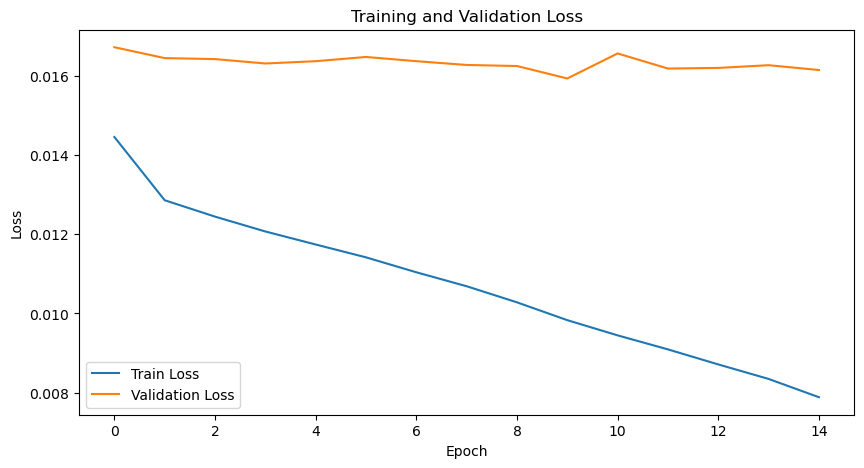

In [13]:
# config
n_epoch = 100
optimizer = optim.Adam(model_finetune.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
criterion = nn.MSELoss()

# early stopping
early_stopping_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

train_losses, val_losses = [], []
r2_scores, pearson_scores = [], []

for epoch in range(n_epoch):
    # train
    running_train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
        optimizer.zero_grad()
        y_pred = model_finetune(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # validate
    model_finetune.eval()
    running_val_loss = 0.0
    y_preds = []
    y_trues = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
            y_pred = model_finetune(x_batch)
            loss = criterion(y_pred, y_batch)
            running_val_loss += loss.item()

            y_preds.append(y_pred.cpu().numpy())
            y_trues.append(y_batch.cpu().numpy())

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)

    # metrics
    y_preds = np.concatenate(y_preds, axis=0)
    y_trues = np.concatenate(y_trues, axis=0)
    r2_score = compute_r2(y_trues, y_preds)
    pearson_score = compute_pearsonr(y_trues, y_preds)
    r2_scores.append(r2_score)
    pearson_scores.append(pearson_score)

    # log and es
    print(f"Epoch {epoch+1}/{n_epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, R2: {r2_score:.4f}, Pearson: {pearson_score:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(model_finetune.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

if best_model_state is not None:
    model_finetune.load_state_dict(best_model_state)
    print("Best model restored.")

# plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig("finetuning_uni_loss_plot.png")
plt.show()

In [14]:
# save the model
torch.save(model_finetune.state_dict(), 'finetuned_uni_model.pth')

# load the model
model_finetune.load_state_dict(torch.load('finetuned_uni_model.pth'))
model_finetune = model_finetune.to('cuda')

# define new transform for uni
transform = create_transform(**resolve_data_config(model_finetune.base.pretrained_cfg, model=model_finetune.base))
model_finetune.eval()

FinetunedUni(
  (base): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1536, kernel_size=(32, 32), stride=(32, 32))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1536, out_features=4608, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1536, out_features=1536, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (mlp): GluMlp(
          (fc1): Linear(in_features=1536, out_features=8192, bias=True)
          (act): SiLU()
      

### Finetuned UNI

In this section we put our finetuned UNI to the test, and see if it can indeed outperform the baseline UNI, or even our baseline CNN, for that matter.

In [15]:
# we now use the finetuned model to get features
# transform pil to tensor and normalize /255, tensorize expression vectors
patch_tensors_train = [transform(patch) for patch in patch_train]
expr_tensors_train = [torch.tensor(e, dtype=torch.float32) for e in expr_train]
patch_tensors_val = [transform(patch) for patch in patch_val]
expr_tensors_val = [torch.tensor(e, dtype=torch.float32) for e in expr_val]
patch_tensors_test = [transform(patch) for patch in patch_test]
expr_tensors_test = [torch.tensor(e, dtype=torch.float32) for e in expr_test]

# get features with uni
with torch.no_grad():
    patch_tensors_train = [model_finetune.base(patch.unsqueeze(0).to('cuda')).cpu().squeeze(0) for patch in patch_tensors_train]
    patch_tensors_val = [model_finetune.base(patch.unsqueeze(0).to('cuda')).cpu().squeeze(0) for patch in patch_tensors_val]
    patch_tensors_test = [model_finetune.base(patch.unsqueeze(0).to('cuda')).cpu().squeeze(0) for patch in patch_tensors_test]
    
# assemble
train_dataset = TensorDataset(torch.stack(patch_tensors_train), torch.stack(expr_tensors_train))
val_dataset = TensorDataset(torch.stack(patch_tensors_val), torch.stack(expr_tensors_val))
test_dataset = TensorDataset(torch.stack(patch_tensors_test), torch.stack(expr_tensors_test))

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/home/b-evelyntong/miniconda3/envs/gutinstinct/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.0177, Val Loss: 0.0171, R2: 0.6513, Pearson: 0.8067
Epoch 2/100, Train Loss: 0.0141, Val Loss: 0.0168, R2: 0.6620, Pearson: 0.8138
Epoch 3/100, Train Loss: 0.0138, Val Loss: 0.0168, R2: 0.6596, Pearson: 0.8137
Epoch 4/100, Train Loss: 0.0135, Val Loss: 0.0166, R2: 0.6650, Pearson: 0.8179
Epoch 5/100, Train Loss: 0.0135, Val Loss: 0.0164, R2: 0.6687, Pearson: 0.8193
Epoch 6/100, Train Loss: 0.0134, Val Loss: 0.0164, R2: 0.6694, Pearson: 0.8199
Epoch 7/100, Train Loss: 0.0134, Val Loss: 0.0162, R2: 0.6743, Pearson: 0.8221
Epoch 8/100, Train Loss: 0.0133, Val Loss: 0.0163, R2: 0.6739, Pearson: 0.8218
Epoch 9/100, Train Loss: 0.0133, Val Loss: 0.0163, R2: 0.6732, Pearson: 0.8218
Epoch 10/100, Train Loss: 0.0134, Val Loss: 0.0161, R2: 0.6786, Pearson: 0.8245
Epoch 11/100, Train Loss: 0.0132, Val Loss: 0.0163, R2: 0.6720, Pearson: 0.8214
Epoch 12/100, Train Loss: 0.0134, Val Loss: 0.0164, R2: 0.6699, Pearson: 0.8207
Epoch 13/100, Train Loss: 0.0133, Val Loss: 0.016

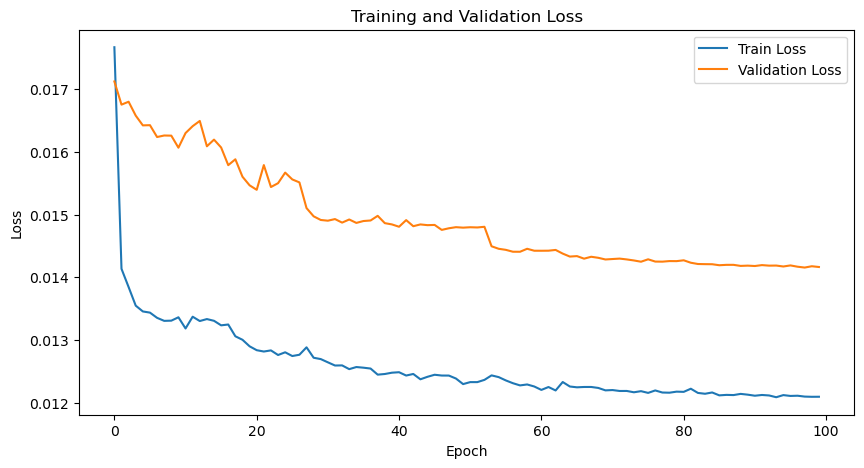

In [16]:
# train the model
model_uni_fintuned = nn.Sequential(
    nn.Linear(1536, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 460),
).to('cuda')

model_uni_fintuned, metrics_uni_finetuned = trainer.train_model(
    model_uni_fintuned,
    train_loader,
    val_loader,
    compute_r2,
    compute_pearsonr,
    num_epochs=100,
    lr=1e-3,
    weight_decay=0.001,
    patience=10,
    save_plot_path='uni_finetuned_loss_plot.png',
    criterion=nn.MSELoss(),
    scheduler_patience=5,
    scheduler_factor=0.5,
    verbose=True,
)


In [38]:
# evaluate baseline on test set
model_uni_fintuned.eval()
model_uni_fintuned.to('cuda')
running_test_loss = 0.0
y_preds = []
y_trues = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
        y_pred = model_uni_fintuned(x_batch)
        loss = criterion(y_pred, y_batch)
        running_test_loss += loss.item()

        y_preds.append(y_pred.cpu().numpy())
        y_trues.append(y_batch.cpu().numpy())

    test_loss = running_test_loss / len(test_loader)
    y_preds = np.concatenate(y_preds, axis=0)
    y_trues = np.concatenate(y_trues, axis=0)
    r2_score = compute_r2(y_trues, y_preds)
    pearson_score = compute_pearsonr(y_trues, y_preds)
    print(f"Test Loss: {test_loss:.4f}, R2: {r2_score:.4f}, Pearson: {pearson_score:.4f}")

metrics_uni_finetuned['test_loss'] = test_loss
metrics_uni_finetuned['test_r2'] = r2_score
metrics_uni_finetuned['test_pearson'] = pearson_score

#Test Loss: 0.0136, R2: 0.7317, Pearson: 0.8539

Test Loss: 0.0136, R2: 0.7317, Pearson: 0.8539


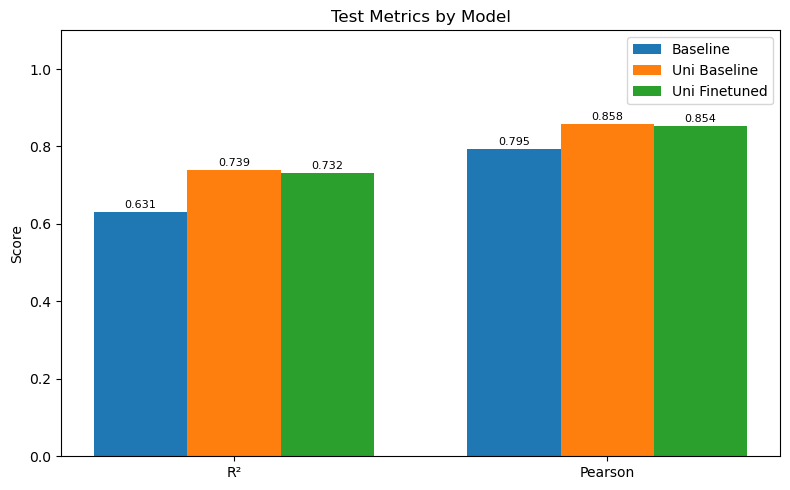

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Data
metrics = ['R²', 'Pearson']
models = ['Baseline', 'Uni Baseline', 'Uni Finetuned']
scores = [
    [metrics_baseline["test_r2"], metrics_baseline["test_pearson"]],
    [metrics_uni_baseline["test_r2"], metrics_uni_baseline["test_pearson"]],
    [metrics_uni_finetuned["test_r2"], metrics_uni_finetuned["test_pearson"]],
]
scores = np.array(scores)
x = np.arange(len(metrics)) 
plt.figure(figsize=(8, 5))
for i, (model, color) in enumerate(zip(models, ['C0', 'C1', 'C2'])):
    bar = plt.bar(x + i*0.25 - 0.25, scores[i], width=0.25, label=model, color=color)
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2, height + 0.005, f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Test Metrics by Model')
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout()
plt.show()


### Results Visualization

In [22]:
# load pickle
with open(osp.expanduser("/home/b-evelyntong/hl/gutinstinct/data/processed/patch_to_expr_UC6_I.pkl"), "rb") as f:
    patch_list = pickle.load(f)
sdata = sd.read_zarr(osp.expanduser("/home/b-evelyntong/hl/ac109_project/raw/UC6_I.zarr/UC6_I.zarr"))
he_img = sdata.images["HE_original"].data
he_img = np.transpose(he_img, (1, 2, 0))

/home/b-evelyntong/miniconda3/envs/gutinstinct/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [4]:
## instantiate a uni model
timm_kwargs = {
   'img_size': 224,
   'patch_size': 32,
   'depth': 24,
   'num_heads': 24,
   'init_values': 1e-5,
   'embed_dim': 1536,
   'mlp_ratio': 2.66667*2,
   'num_classes': 0,
   'no_embed_class': True,
   'mlp_layer': timm.layers.SwiGLUPacked,
   'act_layer': torch.nn.SiLU,
   'reg_tokens': 8,
   'dynamic_img_size': True
  }
model_uni = timm.create_model("hf-hub:MahmoodLab/UNI2-h", pretrained=True, **timm_kwargs)
model_uni = model_uni.to('cuda')

# define new transform for uni
transform = create_transform(**resolve_data_config(model_uni.pretrained_cfg, model=model_uni))
model_uni.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(32, 32), stride=(32, 32))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): GluMlp(
        (fc1): Linear(in_features=1536, out_features=8192, bias=True)
        (act): SiLU()
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
    

In [27]:
patch_transformed = [transform(patch['pil']) for patch in patch_list]
patch_tensor_stack = torch.stack(patch_transformed)
dataset = TensorDataset(patch_tensor_stack)
loader = DataLoader(dataset, batch_size=32, shuffle=False)
model_uni.eval().to('cuda')
patch_tensors = []
with torch.no_grad():
    for batch in loader:
        x = batch[0].to('cuda')
        feats = model_uni(x).cpu()
        patch_tensors.append(feats)
patch_tensors = torch.cat(patch_tensors, dim=0)
expr_tensors = [torch.tensor(patch['expr'], dtype=torch.float32) for patch in patch_list]
dataset = TensorDataset(patch_tensors, torch.stack(expr_tensors), torch.arange(len(patch_list)))
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)


# evaluate
model_uni_baseline.eval().to('cuda')
y_preds = []
indices = []

with torch.no_grad():
    for x_batch, y_batch, idx_batch in dataloader:
        x_batch = x_batch.to('cuda')
        y_pred = model_uni_baseline(x_batch)
        y_preds.append(y_pred.cpu())
        indices.append(idx_batch)

y_preds = torch.cat(y_preds, dim=0)
indices = torch.cat(indices, dim=0)

sorted_preds = y_preds[indices.argsort()].numpy()

In [ ]:
# let's pick a random gene
sdata['anucleus'].var['gene_symbols'][165]

/tmp/ipykernel_2729180/1756648787.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sdata['anucleus'].var['gene_symbols'][165]


'FOLR2'

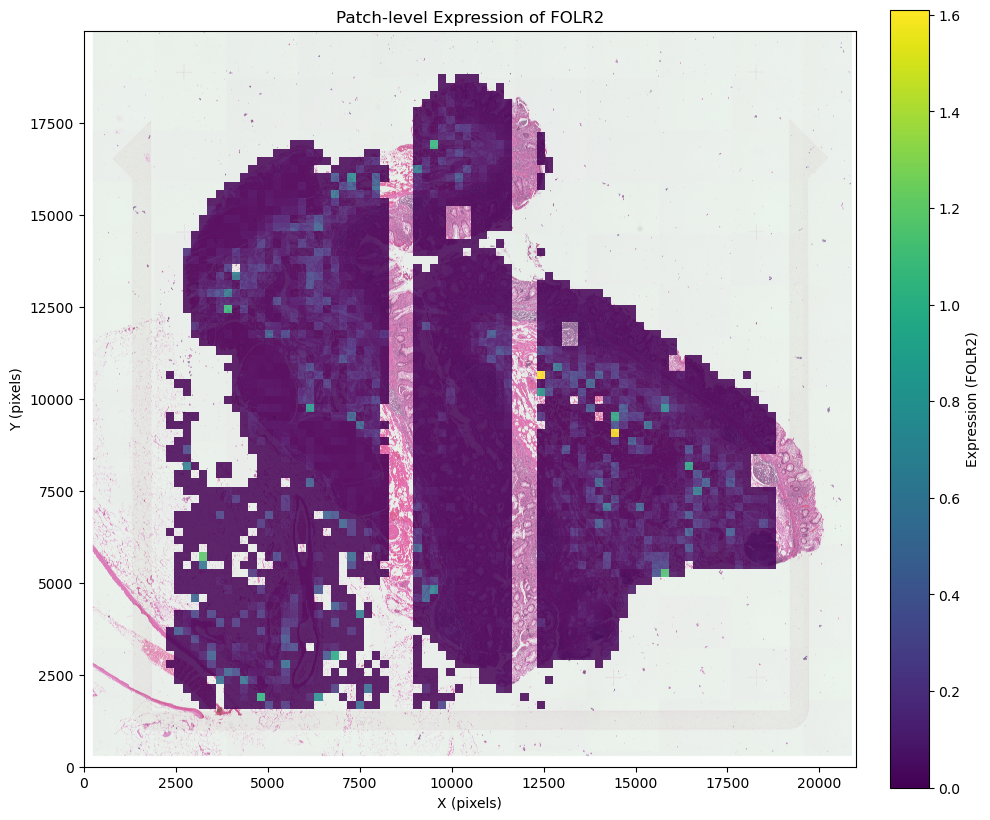

In [36]:
patch_size = 224

expression_vals = [patch['expr'][165] for patch in patch_list]
x_coords = [patch['patch_id'][1] * patch_size for patch in patch_list]
y_coords = [patch['patch_id'][0] * patch_size for patch in patch_list]

norm = plt.Normalize(min(expression_vals), max(expression_vals))
cmap = plt.cm.viridis

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(he_img, alpha=0.7)

for x, y, expr in zip(x_coords, y_coords, expression_vals):
    color = cmap(norm(expr))
    rect = patches.Rectangle((x, y), patch_size, patch_size, linewidth=0,
                             facecolor=color, alpha=0.85)
    ax.add_patch(rect)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Expression (FOLR2)')

ax.set_title("Patch-level Expression of FOLR2")
ax.set_xlabel("X (pixels)")
ax.set_ylabel("Y (pixels)")
ax.invert_yaxis() 
plt.tight_layout()
plt.show()

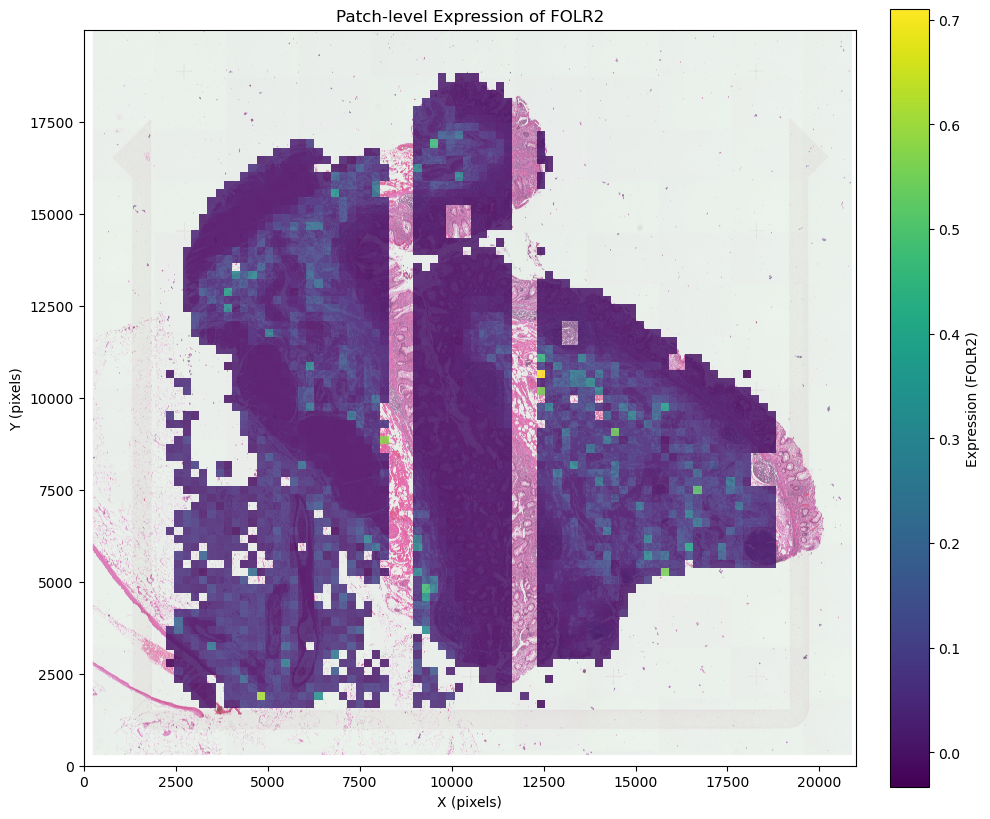

In [37]:
patch_size = 224

expression_vals = sorted_preds[:, 165]
x_coords = [patch['patch_id'][1] * patch_size for patch in patch_list]
y_coords = [patch['patch_id'][0] * patch_size for patch in patch_list]

norm = plt.Normalize(min(expression_vals), max(expression_vals))
cmap = plt.cm.viridis

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(he_img, alpha=0.7)

for x, y, expr in zip(x_coords, y_coords, expression_vals):
    color = cmap(norm(expr))
    rect = patches.Rectangle((x, y), patch_size, patch_size, linewidth=0,
                             facecolor=color, alpha=0.85)
    ax.add_patch(rect)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Expression (FOLR2)')

ax.set_title("Patch-level Expression of FOLR2")
ax.set_xlabel("X (pixels)")
ax.set_ylabel("Y (pixels)")
ax.invert_yaxis() 
plt.tight_layout()
plt.show()

# Citation
Broad Institute autoimmune disease. CrunchDAO Docs V3. (2024a). https://docs.crunchdao.com/competitions/competitions/broad-institute-autoimmune-disease \
Chen, R.J., Ding, T., Lu, M.Y. et al. Towards a general-purpose foundation model for computational pathology. Nat Med 30, 850–862 (2024). https://doi.org/10.1038/s41591-024-02857-3 \
Bunne, C., Stark, S.G., Gut, G. et al. Learning single-cell perturbation responses using neural optimal transport. Nat Methods 20, 1759–1768 (2023). https://doi.org/10.1038/s41592-023-01969-x \
Roohani, Y., Huang, K. & Leskovec, J. Predicting transcriptional outcomes of novel multigene perturbations with GEARS. Nat Biotechnol 42, 927–935 (2024). https://doi.org/10.1038/s41587-023-01905-6